# 🌍 Qartezator: Yet another aerial image-to-map translator

## Environment setup

First you need to install qartezator from project root directory

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


## Setup Dataloaders

In [2]:
import torch
from PIL import Image

from qartezator.data.dataset import QartezatorDataset
from qartezator.data.datamodule import QartezatorDataModule
from qartezator.data.transforms import get_common_augmentations

In [3]:
root_path = './data/maps'
train_txt_path = './assets/train.txt'
val_txt_path = './assets/val.txt'
test_txt_path = './assets/test.txt'

In [4]:
ds = QartezatorDataset(
    root_path=root_path,
    split_file_path=train_txt_path,
    common_transform=get_common_augmentations(256)
)
sample_source_img, sample_target_img = ds[42]

In [23]:
sample_target_img.shape

(256, 256, 3)

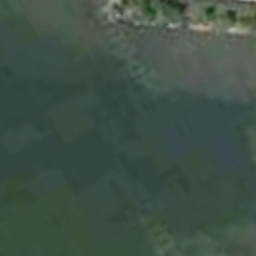

In [5]:
import numpy as np

Image.fromarray((sample_source_img * 255).astype(np.uint8))

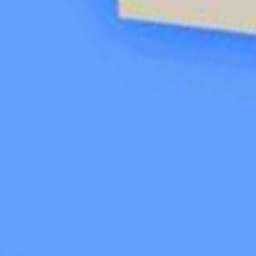

In [6]:
Image.fromarray((sample_target_img * 255).astype(np.uint8))

In [7]:
dm = QartezatorDataModule(
    root_path=root_path,
    train_txt_path=train_txt_path,
    val_txt_path=val_txt_path,
    test_txt_path=test_txt_path,
    input_size=256
)
train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()
test_dataloader = dm.test_dataloader()

In [7]:
for batch in train_dataloader:
    source, target = batch
    print(f'Source batch shape: {source.shape}')
    print(f'Target batch shape: {target.shape}\n')
    break

Source batch shape: torch.Size([32, 3, 256, 256])
Target batch shape: torch.Size([32, 3, 256, 256])



In [10]:
len(train_dataloader.dataset)

2792

In [11]:
len(val_dataloader.dataset)

250

In [12]:
len(test_dataloader.dataset)

250

In [24]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import os
from glob import glob
from tqdm import trange
from itertools import chain

import torch.nn.parallel
import torchvision.utils as vutils
from torch.autograd import Variable
import itertools
import torchvision

# from data_loader import get_loader

In [11]:
class GeneratorCNN(nn.Module):
    def __init__(self, input_channel, output_channel, conv_dims = [32, 64, 128, 256], deconv_dims = [128, 64, 32]):
        super(GeneratorCNN, self).__init__()
        self.num_gpu = 1
        self.layers = []

        prev_dim = conv_dims[0]
        self.layers.append(nn.Conv2d(input_channel, prev_dim, 4, 2, 1, bias=False))
        self.layers.append(nn.LeakyReLU(0.2, inplace=True))

        for out_dim in conv_dims[1:]:
            self.layers.append(nn.Conv2d(prev_dim, out_dim, 4, 2, 1, bias=False))
            self.layers.append(nn.BatchNorm2d(out_dim))
            self.layers.append(nn.LeakyReLU(0.2, inplace=True))
            prev_dim = out_dim

        for out_dim in deconv_dims:
            self.layers.append(nn.ConvTranspose2d(prev_dim, out_dim, 4, 2, 1, bias=False))
            self.layers.append(nn.BatchNorm2d(out_dim))
            self.layers.append(nn.ReLU(True))
            prev_dim = out_dim

        self.layers.append(nn.ConvTranspose2d(prev_dim, output_channel, 4, 2, 1, bias=False))
        self.layers.append(nn.Tanh())

        self.layer_module = nn.ModuleList(self.layers)

    def main(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out

    def forward(self, x):
        return self.main(x)


In [12]:
class DiscriminatorCNN(nn.Module):
    def __init__(self, input_channel, output_channel, hidden_dims= [32, 64, 128, 256]):
        super(DiscriminatorCNN, self).__init__()
        self.layers = []

        prev_dim = hidden_dims[0]
        self.layers.append(nn.Conv2d(input_channel, prev_dim, 4, 2, 1, bias=False))
        self.layers.append(nn.LeakyReLU(0.2, inplace=True))

        for out_dim in hidden_dims[1:]:
            self.layers.append(nn.Conv2d(prev_dim, out_dim, 4, 2, 1, bias=False))
            self.layers.append(nn.BatchNorm2d(out_dim))
            self.layers.append(nn.LeakyReLU(0.2, inplace=True))
            prev_dim = out_dim

        self.layers.append(nn.Conv2d(prev_dim, output_channel, 4, 1, 0, bias=False))
        self.layers.append(nn.Sigmoid())

        self.layer_module = nn.ModuleList(self.layers)

    def main(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out.view(out.size(0), -1)

    def forward(self, x):
        return self.main(x)


In [ ]:
def generate_with_A(inputs, path, idx=None):
    x_AB = G_AB(inputs)
    x_ABA = G_BA(x_AB)
    
    input_path = '{}/{}_input_A.png'.format(path, idx)
    x_AB_path = '{}/{}_x_AB.png'.format(path, idx)
    x_ABA_path = '{}/{}_x_ABA.png'.format(path, idx)
    vutils.save_image(inputs, input_path, normalize=True)
    vutils.save_image(x_AB.data, x_AB_path, normalize=True)
    print("[*] Samples saved: {}".format(x_AB_path))

    vutils.save_image(x_ABA.data, x_ABA_path, normalize=True)
    print("[*] Samples saved: {}".format(x_ABA_path))
    
    
def generate_with_B(inputs, path, idx=None):
    x_BA = G_BA(inputs)
    x_BAB = G_AB(x_BA)
    
    input_path = '{}/{}_input_B.png'.format(path, idx)
    x_BA_path = '{}/{}_x_BA.png'.format(path, idx)
    x_BAB_path = '{}/{}_x_BAB.png'.format(path, idx)
    
    vutils.save_image(inputs, input_path, normalize=True)
    vutils.save_image(x_BA.data, x_BA_path, normalize=True)
    print("[*] Samples saved: {}".format(x_BA_path))

    vutils.save_image(x_BAB.data, x_BAB_path, normalize=True)
    print("[*] Samples saved: {}".format(x_BAB_path))



In [ ]:
def load_model():
    print("[*] Load models from {}...".format('model'))

    paths = glob(os.path.join('model', 'G_AB_*.pth'))
    paths.sort()

    if len(paths) == 0:
        print("[!] No checkpoint found in {}...".format('model'))
        return

    idxes = [int(os.path.basename(path.split('.')[0].split('_')[-1])) for path in paths]
    start_step = max(idxes)
    G_AB_filename = '{}/G_AB_{}.pth'.format('model', start_step)
    G_AB.load_state_dict(torch.load(G_AB_filename))
    G_BA.load_state_dict(torch.load('{}/G_BA_{}.pth'.format('model', start_step)))

    D_A.load_state_dict(torch.load('{}/D_A_{}.pth'.format('model', start_step)))
    D_B.load_state_dict(torch.load('{}/D_B_{}.pth'.format('model', start_step)))

    print("[*] Model loaded: {}".format(G_AB_filename))



In [25]:
input_dim = 3
output_dim = 3

G_AB = GeneratorCNN(input_dim, output_dim).cuda()
G_BA = GeneratorCNN(input_dim, output_dim).cuda()
D_A = DiscriminatorCNN(input_dim, 1).cuda()
D_B = DiscriminatorCNN(input_dim, 1).cuda()


G_AB.apply(weights_init)
G_BA.apply(weights_init)

D_A.apply(weights_init)
D_B.apply(weights_init)


DiscriminatorCNN(
  (layer_module): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [22]:
d = nn.MSELoss()
bce = nn.BCELoss()

real_label = 1
fake_label = 0

real_tensor = Variable(torch.FloatTensor(32))
_ = real_tensor.data.fill_(real_label)

fake_tensor = Variable(torch.FloatTensor(32))
_ = fake_tensor.data.fill_(fake_label)

d.cuda()
bce.cuda()

real_tensor = real_tensor.cuda()
fake_tensor = fake_tensor.cuda()

optimizer = torch.optim.Adam

optimizer_d = optimizer(
    chain(D_A.parameters(), D_B.parameters()),
    lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0001)
optimizer_g = optimizer(
    chain(G_AB.parameters(), G_BA.parameters()),
    lr=0.0002, betas=(0.5, 0.999))

train_loader = iter(train_dataloader)
# valid_x_A, valid_x_B = self._get_variable(A_loader.next()), self._get_variable(B_loader.next())

# vutils.save_image(valid_x_A.data, '{}/valid_x_A.png'.format(self.model_dir))
# vutils.save_image(valid_x_B.data, '{}/valid_x_B.png'.format(self.model_dir))

for step in trange(50000, 55000):
    try:
        x_A, x_B = next(train_loader)
    except StopIteration:
        train_loader = iter(train_dataloader)
        x_A, x_B = next(train_loader)
    if x_A.size(0) != x_B.size(0):
        print("[!] Sampled dataset from A and B have different # of data. Try resampling...")
        continue

    x_A, x_B = Variable(x_A.cuda()), Variable(x_B.cuda())

    batch_size = x_A.size(0)
    real_tensor.resize_(batch_size).fill_(real_label)
    fake_tensor.resize_(batch_size).fill_(fake_label)

    # update D network
    D_A.zero_grad()
    D_B.zero_grad()

    x_AB = G_AB(x_A).detach()
    x_BA = G_BA(x_B).detach()

    x_ABA = G_BA(x_AB).detach()
    x_BAB = G_AB(x_BA).detach()
    
#     l_d_A_real, l_d_A_fake = bce(D_A(x_A), real_tensor), bce(D_A(x_BA), fake_tensor)
#     l_d_B_real, l_d_B_fake = bce(D_B(x_B), real_tensor), bce(D_B(x_AB), fake_tensor)
    
    l_d_A_real, l_d_A_fake = \
        0.5 * torch.mean((D_A(x_A) - 1)**2), 0.5 * torch.mean((D_A(x_BA))**2)
    l_d_B_real, l_d_B_fake = \
        0.5 * torch.mean((D_B(x_B) - 1)**2), 0.5 * torch.mean((D_B(x_AB))**2)

#     if self.loss == "log_prob":
#         l_d_A_real, l_d_A_fake = bce(self.D_A(x_A), real_tensor), bce(self.D_A(x_BA), fake_tensor)
#         l_d_B_real, l_d_B_fake = bce(self.D_B(x_B), real_tensor), bce(self.D_B(x_AB), fake_tensor)
#     elif self.loss == "least_square":
#         l_d_A_real, l_d_A_fake = \
#             0.5 * torch.mean((self.D_A(x_A) - 1)**2), 0.5 * torch.mean((self.D_A(x_BA))**2)
#         l_d_B_real, l_d_B_fake = \
#             0.5 * torch.mean((self.D_B(x_B) - 1)**2), 0.5 * torch.mean((self.D_B(x_AB))**2)
#     else:
#         raise Exception("[!] Unkown loss type: {}".format(self.loss))

    l_d_A = l_d_A_real + l_d_A_fake
    l_d_B = l_d_B_real + l_d_B_fake

    l_d = l_d_A + l_d_B

    l_d.backward()
    optimizer_d.step()

    # update G network
    G_AB.zero_grad()
    G_BA.zero_grad()

    x_AB = G_AB(x_A)
    x_BA = G_BA(x_B)

    x_ABA = G_BA(x_AB)
    x_BAB = G_AB(x_BA)

    l_const_A = d(x_ABA, x_A)
    l_const_B = d(x_BAB, x_B)
    
#     l_gan_A = bce(D_A(x_BA), real_tensor)
#     l_gan_B = bce(D_B(x_AB), real_tensor)
    l_gan_A = 0.5 * torch.mean((D_A(x_BA) - 1)**2)
    l_gan_B = 0.5 * torch.mean((D_B(x_AB) - 1)**2)

#     if self.loss == "log_prob":
#         l_gan_A = bce(self.D_A(x_BA), real_tensor)
#         l_gan_B = bce(self.D_B(x_AB), real_tensor)
#     elif self.loss == "least_square":
#         l_gan_A = 0.5 * torch.mean((self.D_A(x_BA) - 1)**2)
#         l_gan_B = 0.5 * torch.mean((self.D_B(x_AB) - 1)**2)
#     else:
#         raise Exception("[!] Unkown loss type: {}".format(self.loss))

    l_g = l_gan_A + l_gan_B + l_const_A + l_const_B

    l_g.backward()
    optimizer_g.step()

    if step % 50 == 0:
        print("[{}/{}] Loss_D: {:.4f} Loss_G: {:.4f}". \
              format(step, 100, l_d.item(), l_g.item()))

        print("[{}/{}] l_d_A_real: {:.4f} l_d_A_fake: {:.4f}, l_d_B_real: {:.4f}, l_d_B_fake: {:.4f}". \
              format(step, 100, l_d_A_real.item(), l_d_A_fake.item(),
                     l_d_B_real.item(), l_d_B_fake.item()))

        print("[{}/{}] l_const_A: {:.4f} l_const_B: {:.4f}, l_gan_A: {:.4f}, l_gan_B: {:.4f}". \
              format(step, 100, l_const_A.item(), l_const_B.item(),
                     l_gan_A.item(), l_gan_B.item()))

        generate_with_A(x_A, 'model', idx=step)
        generate_with_B(x_B, 'model', idx=step)

    if step % 50 == 50 - 1:
        print("[*] Save models to {}...".format('model'))

        torch.save(G_AB.state_dict(), '{}/G_AB_{}.pth'.format('model', step))
        torch.save(G_BA.state_dict(), '{}/G_BA_{}.pth'.format('model', step))

        torch.save(D_A.state_dict(), '{}/D_A_{}.pth'.format('model', step))
        torch.save(D_B.state_dict(), '{}/D_B_{}.pth'.format('model', step))



  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[50000/100] Loss_D: 0.0103 Loss_G: 0.9995
[50000/100] l_d_A_real: 0.0004 l_d_A_fake: 0.0044, l_d_B_real: 0.0051, l_d_B_fake: 0.0005
[50000/100] l_const_A: 0.0304 l_const_B: 0.0159, l_gan_A: 0.4856, l_gan_B: 0.4675
[*] Samples saved: model/50000_x_AB.png
[*] Samples saved: model/50000_x_ABA.png
[*] Samples saved: model/50000_x_BA.png


  0%|                                                                               | 2/5000 [00:08<4:57:15,  3.57s/it]

[*] Samples saved: model/50000_x_BAB.png


  1%|▊                                                                             | 49/5000 [01:18<2:02:23,  1.48s/it]

[*] Save models to model...


  1%|▊                                                                             | 50/5000 [01:21<2:38:55,  1.93s/it]

[50050/100] Loss_D: 0.0472 Loss_G: 0.9279
[50050/100] l_d_A_real: 0.0359 l_d_A_fake: 0.0071, l_d_B_real: 0.0007, l_d_B_fake: 0.0034
[50050/100] l_const_A: 0.0300 l_const_B: 0.0157, l_gan_A: 0.4219, l_gan_B: 0.4602
[*] Samples saved: model/50050_x_AB.png
[*] Samples saved: model/50050_x_ABA.png
[*] Samples saved: model/50050_x_BA.png


  1%|▊                                                                             | 51/5000 [01:30<5:33:40,  4.05s/it]

[*] Samples saved: model/50050_x_BAB.png


  2%|█▌                                                                            | 99/5000 [02:46<2:00:55,  1.48s/it]

[*] Save models to model...


  2%|█▌                                                                           | 100/5000 [02:49<2:37:10,  1.92s/it]

[50100/100] Loss_D: 0.0157 Loss_G: 1.0189
[50100/100] l_d_A_real: 0.0003 l_d_A_fake: 0.0003, l_d_B_real: 0.0000, l_d_B_fake: 0.0152
[50100/100] l_const_A: 0.0400 l_const_B: 0.0123, l_gan_A: 0.4894, l_gan_B: 0.4772
[*] Samples saved: model/50100_x_AB.png
[*] Samples saved: model/50100_x_ABA.png
[*] Samples saved: model/50100_x_BA.png


  2%|█▌                                                                           | 102/5000 [02:58<3:53:40,  2.86s/it]

[*] Samples saved: model/50100_x_BAB.png


  3%|██▎                                                                          | 149/5000 [04:15<2:39:43,  1.98s/it]

[*] Save models to model...


  3%|██▎                                                                          | 150/5000 [04:18<3:03:26,  2.27s/it]

[50150/100] Loss_D: 0.0052 Loss_G: 1.0029
[50150/100] l_d_A_real: 0.0004 l_d_A_fake: 0.0013, l_d_B_real: 0.0033, l_d_B_fake: 0.0002
[50150/100] l_const_A: 0.0215 l_const_B: 0.0173, l_gan_A: 0.4817, l_gan_B: 0.4824
[*] Samples saved: model/50150_x_AB.png
[*] Samples saved: model/50150_x_ABA.png
[*] Samples saved: model/50150_x_BA.png


  3%|██▎                                                                          | 152/5000 [04:28<4:21:34,  3.24s/it]

[*] Samples saved: model/50150_x_BAB.png


  4%|███                                                                          | 199/5000 [05:38<2:00:09,  1.50s/it]

[*] Save models to model...


  4%|███                                                                          | 200/5000 [05:41<2:35:52,  1.95s/it]

[50200/100] Loss_D: 0.0667 Loss_G: 0.9546
[50200/100] l_d_A_real: 0.0624 l_d_A_fake: 0.0040, l_d_B_real: 0.0000, l_d_B_fake: 0.0002
[50200/100] l_const_A: 0.0282 l_const_B: 0.0154, l_gan_A: 0.4263, l_gan_B: 0.4847
[*] Samples saved: model/50200_x_AB.png
[*] Samples saved: model/50200_x_ABA.png
[*] Samples saved: model/50200_x_BA.png


  4%|███                                                                          | 202/5000 [05:51<4:08:59,  3.11s/it]

[*] Samples saved: model/50200_x_BAB.png


  5%|███▊                                                                         | 249/5000 [07:09<2:02:31,  1.55s/it]

[*] Save models to model...


  5%|███▊                                                                         | 250/5000 [07:12<2:40:44,  2.03s/it]

[50250/100] Loss_D: 0.0189 Loss_G: 0.8679
[50250/100] l_d_A_real: 0.0086 l_d_A_fake: 0.0081, l_d_B_real: 0.0015, l_d_B_fake: 0.0008
[50250/100] l_const_A: 0.0326 l_const_B: 0.0168, l_gan_A: 0.3465, l_gan_B: 0.4720
[*] Samples saved: model/50250_x_AB.png
[*] Samples saved: model/50250_x_ABA.png
[*] Samples saved: model/50250_x_BA.png


  5%|███▉                                                                         | 252/5000 [07:22<4:11:50,  3.18s/it]

[*] Samples saved: model/50250_x_BAB.png


  6%|████▌                                                                        | 299/5000 [08:35<2:02:33,  1.56s/it]

[*] Save models to model...


  6%|████▌                                                                        | 300/5000 [08:38<2:39:11,  2.03s/it]

[50300/100] Loss_D: 0.0868 Loss_G: 0.8340
[50300/100] l_d_A_real: 0.0802 l_d_A_fake: 0.0033, l_d_B_real: 0.0000, l_d_B_fake: 0.0033
[50300/100] l_const_A: 0.0246 l_const_B: 0.0154, l_gan_A: 0.3424, l_gan_B: 0.4516
[*] Samples saved: model/50300_x_AB.png
[*] Samples saved: model/50300_x_ABA.png
[*] Samples saved: model/50300_x_BA.png


  6%|████▋                                                                        | 302/5000 [08:48<4:01:51,  3.09s/it]

[*] Samples saved: model/50300_x_BAB.png


  7%|█████▎                                                                       | 349/5000 [10:08<2:04:16,  1.60s/it]

[*] Save models to model...


  7%|█████▍                                                                       | 350/5000 [10:11<2:39:13,  2.05s/it]

[50350/100] Loss_D: 0.1081 Loss_G: 0.9752
[50350/100] l_d_A_real: 0.1029 l_d_A_fake: 0.0049, l_d_B_real: 0.0000, l_d_B_fake: 0.0002
[50350/100] l_const_A: 0.0302 l_const_B: 0.0146, l_gan_A: 0.4405, l_gan_B: 0.4899
[*] Samples saved: model/50350_x_AB.png
[*] Samples saved: model/50350_x_ABA.png
[*] Samples saved: model/50350_x_BA.png


  7%|█████▍                                                                       | 352/5000 [10:21<4:04:03,  3.15s/it]

[*] Samples saved: model/50350_x_BAB.png


  8%|██████▏                                                                      | 399/5000 [11:36<2:05:38,  1.64s/it]

[*] Save models to model...


  8%|██████▏                                                                      | 400/5000 [11:39<2:41:52,  2.11s/it]

[50400/100] Loss_D: 0.1114 Loss_G: 0.9538
[50400/100] l_d_A_real: 0.0554 l_d_A_fake: 0.0130, l_d_B_real: 0.0000, l_d_B_fake: 0.0430
[50400/100] l_const_A: 0.0266 l_const_B: 0.0219, l_gan_A: 0.4102, l_gan_B: 0.4950
[*] Samples saved: model/50400_x_AB.png
[*] Samples saved: model/50400_x_ABA.png
[*] Samples saved: model/50400_x_BA.png


  8%|██████▏                                                                      | 402/5000 [11:50<4:10:22,  3.27s/it]

[*] Samples saved: model/50400_x_BAB.png


  9%|██████▉                                                                      | 449/5000 [13:10<2:03:17,  1.63s/it]

[*] Save models to model...


  9%|██████▉                                                                      | 450/5000 [13:14<2:43:27,  2.16s/it]

[50450/100] Loss_D: 0.0191 Loss_G: 0.9883
[50450/100] l_d_A_real: 0.0001 l_d_A_fake: 0.0023, l_d_B_real: 0.0165, l_d_B_fake: 0.0001
[50450/100] l_const_A: 0.0262 l_const_B: 0.0144, l_gan_A: 0.4760, l_gan_B: 0.4717
[*] Samples saved: model/50450_x_AB.png
[*] Samples saved: model/50450_x_ABA.png
[*] Samples saved: model/50450_x_BA.png


  9%|██████▉                                                                      | 452/5000 [13:24<4:06:40,  3.25s/it]

[*] Samples saved: model/50450_x_BAB.png


 10%|███████▋                                                                     | 499/5000 [14:45<2:09:39,  1.73s/it]

[*] Save models to model...


 10%|███████▋                                                                     | 500/5000 [14:48<2:41:20,  2.15s/it]

[50500/100] Loss_D: 0.1036 Loss_G: 0.9225
[50500/100] l_d_A_real: 0.0102 l_d_A_fake: 0.0049, l_d_B_real: 0.0243, l_d_B_fake: 0.0642
[50500/100] l_const_A: 0.0308 l_const_B: 0.0144, l_gan_A: 0.4652, l_gan_B: 0.4121
[*] Samples saved: model/50500_x_AB.png
[*] Samples saved: model/50500_x_ABA.png
[*] Samples saved: model/50500_x_BA.png


 10%|███████▋                                                                     | 502/5000 [14:59<4:05:26,  3.27s/it]

[*] Samples saved: model/50500_x_BAB.png


 11%|████████▍                                                                    | 549/5000 [16:14<2:03:30,  1.66s/it]

[*] Save models to model...


 11%|████████▍                                                                    | 550/5000 [16:17<2:38:29,  2.14s/it]

[50550/100] Loss_D: 0.1179 Loss_G: 0.9305
[50550/100] l_d_A_real: 0.1092 l_d_A_fake: 0.0055, l_d_B_real: 0.0028, l_d_B_fake: 0.0005
[50550/100] l_const_A: 0.0222 l_const_B: 0.0205, l_gan_A: 0.4082, l_gan_B: 0.4796
[*] Samples saved: model/50550_x_AB.png
[*] Samples saved: model/50550_x_ABA.png
[*] Samples saved: model/50550_x_BA.png


 11%|████████▌                                                                    | 552/5000 [16:28<4:08:23,  3.35s/it]

[*] Samples saved: model/50550_x_BAB.png


 12%|█████████▏                                                                   | 599/5000 [17:50<1:56:20,  1.59s/it]

[*] Save models to model...


 12%|█████████▏                                                                   | 600/5000 [17:54<2:35:36,  2.12s/it]

[50600/100] Loss_D: 0.1003 Loss_G: 0.9796
[50600/100] l_d_A_real: 0.0024 l_d_A_fake: 0.0965, l_d_B_real: 0.0005, l_d_B_fake: 0.0009
[50600/100] l_const_A: 0.0233 l_const_B: 0.0140, l_gan_A: 0.4548, l_gan_B: 0.4874
[*] Samples saved: model/50600_x_AB.png
[*] Samples saved: model/50600_x_ABA.png
[*] Samples saved: model/50600_x_BA.png


 12%|█████████▎                                                                   | 602/5000 [18:04<4:02:20,  3.31s/it]

[*] Samples saved: model/50600_x_BAB.png


 13%|█████████▉                                                                   | 649/5000 [19:21<2:01:36,  1.68s/it]

[*] Save models to model...


 13%|██████████                                                                   | 650/5000 [19:24<2:38:20,  2.18s/it]

[50650/100] Loss_D: 0.0021 Loss_G: 1.0221
[50650/100] l_d_A_real: 0.0012 l_d_A_fake: 0.0006, l_d_B_real: 0.0002, l_d_B_fake: 0.0001
[50650/100] l_const_A: 0.0245 l_const_B: 0.0142, l_gan_A: 0.4913, l_gan_B: 0.4920
[*] Samples saved: model/50650_x_AB.png
[*] Samples saved: model/50650_x_ABA.png
[*] Samples saved: model/50650_x_BA.png


 13%|██████████                                                                   | 652/5000 [19:34<3:55:52,  3.25s/it]

[*] Samples saved: model/50650_x_BAB.png


 14%|██████████▊                                                                  | 699/5000 [20:56<2:00:57,  1.69s/it]

[*] Save models to model...


 14%|██████████▊                                                                  | 700/5000 [20:59<2:34:38,  2.16s/it]

[50700/100] Loss_D: 0.1368 Loss_G: 0.8625
[50700/100] l_d_A_real: 0.0855 l_d_A_fake: 0.0169, l_d_B_real: 0.0344, l_d_B_fake: 0.0001
[50700/100] l_const_A: 0.0282 l_const_B: 0.0136, l_gan_A: 0.4221, l_gan_B: 0.3986
[*] Samples saved: model/50700_x_AB.png
[*] Samples saved: model/50700_x_ABA.png
[*] Samples saved: model/50700_x_BA.png


 14%|██████████▊                                                                  | 702/5000 [21:09<3:43:00,  3.11s/it]

[*] Samples saved: model/50700_x_BAB.png


 15%|███████████▌                                                                 | 749/5000 [22:26<1:58:10,  1.67s/it]

[*] Save models to model...


 15%|███████████▌                                                                 | 750/5000 [22:29<2:34:55,  2.19s/it]

[50750/100] Loss_D: 0.0036 Loss_G: 1.0107
[50750/100] l_d_A_real: 0.0002 l_d_A_fake: 0.0009, l_d_B_real: 0.0024, l_d_B_fake: 0.0001
[50750/100] l_const_A: 0.0274 l_const_B: 0.0155, l_gan_A: 0.4808, l_gan_B: 0.4871
[*] Samples saved: model/50750_x_AB.png
[*] Samples saved: model/50750_x_ABA.png
[*] Samples saved: model/50750_x_BA.png


 15%|███████████▌                                                                 | 752/5000 [22:40<3:57:40,  3.36s/it]

[*] Samples saved: model/50750_x_BAB.png


 16%|████████████▎                                                                | 799/5000 [24:03<1:55:51,  1.65s/it]

[*] Save models to model...


 16%|████████████▎                                                                | 800/5000 [24:06<2:32:34,  2.18s/it]

[50800/100] Loss_D: 0.0020 Loss_G: 1.0000
[50800/100] l_d_A_real: 0.0001 l_d_A_fake: 0.0004, l_d_B_real: 0.0005, l_d_B_fake: 0.0010
[50800/100] l_const_A: 0.0369 l_const_B: 0.0143, l_gan_A: 0.4907, l_gan_B: 0.4581
[*] Samples saved: model/50800_x_AB.png
[*] Samples saved: model/50800_x_ABA.png
[*] Samples saved: model/50800_x_BA.png


 16%|████████████▎                                                                | 802/5000 [24:16<3:36:15,  3.09s/it]

[*] Samples saved: model/50800_x_BAB.png


 17%|█████████████                                                                | 849/5000 [25:38<1:55:11,  1.66s/it]

[*] Save models to model...


 17%|█████████████                                                                | 850/5000 [25:41<2:25:16,  2.10s/it]

[50850/100] Loss_D: 0.1499 Loss_G: 1.0005
[50850/100] l_d_A_real: 0.0025 l_d_A_fake: 0.0020, l_d_B_real: 0.1453, l_d_B_fake: 0.0001
[50850/100] l_const_A: 0.0335 l_const_B: 0.0125, l_gan_A: 0.4732, l_gan_B: 0.4814
[*] Samples saved: model/50850_x_AB.png
[*] Samples saved: model/50850_x_ABA.png
[*] Samples saved: model/50850_x_BA.png


 17%|█████████████                                                                | 851/5000 [25:50<5:01:57,  4.37s/it]

[*] Samples saved: model/50850_x_BAB.png


 18%|█████████████▊                                                               | 899/5000 [27:08<1:55:59,  1.70s/it]

[*] Save models to model...


 18%|█████████████▊                                                               | 900/5000 [27:11<2:27:18,  2.16s/it]

[50900/100] Loss_D: 0.0034 Loss_G: 0.9571
[50900/100] l_d_A_real: 0.0003 l_d_A_fake: 0.0016, l_d_B_real: 0.0001, l_d_B_fake: 0.0014
[50900/100] l_const_A: 0.0252 l_const_B: 0.0133, l_gan_A: 0.4834, l_gan_B: 0.4351
[*] Samples saved: model/50900_x_AB.png
[*] Samples saved: model/50900_x_ABA.png
[*] Samples saved: model/50900_x_BA.png


 18%|█████████████▉                                                               | 901/5000 [27:20<4:59:00,  4.38s/it]

[*] Samples saved: model/50900_x_BAB.png


 19%|██████████████▌                                                              | 949/5000 [28:44<1:49:24,  1.62s/it]

[*] Save models to model...


 19%|██████████████▋                                                              | 950/5000 [28:48<2:21:43,  2.10s/it]

[50950/100] Loss_D: 0.0155 Loss_G: 0.9975
[50950/100] l_d_A_real: 0.0115 l_d_A_fake: 0.0035, l_d_B_real: 0.0004, l_d_B_fake: 0.0002
[50950/100] l_const_A: 0.0297 l_const_B: 0.0179, l_gan_A: 0.4635, l_gan_B: 0.4863
[*] Samples saved: model/50950_x_AB.png
[*] Samples saved: model/50950_x_ABA.png
[*] Samples saved: model/50950_x_BA.png


 19%|██████████████▋                                                              | 952/5000 [28:58<3:37:54,  3.23s/it]

[*] Samples saved: model/50950_x_BAB.png


 20%|███████████████▍                                                             | 999/5000 [30:15<1:52:46,  1.69s/it]

[*] Save models to model...


 20%|███████████████▏                                                            | 1000/5000 [30:19<2:26:31,  2.20s/it]

[51000/100] Loss_D: 0.0140 Loss_G: 1.0065
[51000/100] l_d_A_real: 0.0090 l_d_A_fake: 0.0047, l_d_B_real: 0.0001, l_d_B_fake: 0.0002
[51000/100] l_const_A: 0.0305 l_const_B: 0.0188, l_gan_A: 0.4705, l_gan_B: 0.4867
[*] Samples saved: model/51000_x_AB.png
[*] Samples saved: model/51000_x_ABA.png
[*] Samples saved: model/51000_x_BA.png


 20%|███████████████▏                                                            | 1002/5000 [30:29<3:39:17,  3.29s/it]

[*] Samples saved: model/51000_x_BAB.png


 21%|███████████████▉                                                            | 1049/5000 [31:52<1:51:22,  1.69s/it]

[*] Save models to model...


 21%|███████████████▉                                                            | 1050/5000 [31:55<2:22:49,  2.17s/it]

[51050/100] Loss_D: 0.3612 Loss_G: 0.8325
[51050/100] l_d_A_real: 0.0157 l_d_A_fake: 0.3433, l_d_B_real: 0.0017, l_d_B_fake: 0.0006
[51050/100] l_const_A: 0.0340 l_const_B: 0.0132, l_gan_A: 0.3111, l_gan_B: 0.4742
[*] Samples saved: model/51050_x_AB.png
[*] Samples saved: model/51050_x_ABA.png
[*] Samples saved: model/51050_x_BA.png


 21%|███████████████▉                                                            | 1052/5000 [32:05<3:27:40,  3.16s/it]

[*] Samples saved: model/51050_x_BAB.png


 22%|████████████████▋                                                           | 1099/5000 [33:23<1:50:09,  1.69s/it]

[*] Save models to model...


 22%|████████████████▋                                                           | 1100/5000 [33:26<2:22:48,  2.20s/it]

[51100/100] Loss_D: 0.0271 Loss_G: 0.9833
[51100/100] l_d_A_real: 0.0056 l_d_A_fake: 0.0213, l_d_B_real: 0.0000, l_d_B_fake: 0.0001
[51100/100] l_const_A: 0.0364 l_const_B: 0.0184, l_gan_A: 0.4392, l_gan_B: 0.4894
[*] Samples saved: model/51100_x_AB.png
[*] Samples saved: model/51100_x_ABA.png
[*] Samples saved: model/51100_x_BA.png


 22%|████████████████▋                                                           | 1101/5000 [33:36<4:59:15,  4.61s/it]

[*] Samples saved: model/51100_x_BAB.png


 23%|█████████████████▍                                                          | 1149/5000 [35:01<1:45:44,  1.65s/it]

[*] Save models to model...


 23%|█████████████████▍                                                          | 1150/5000 [35:05<2:17:29,  2.14s/it]

[51150/100] Loss_D: 0.1089 Loss_G: 0.9418
[51150/100] l_d_A_real: 0.0062 l_d_A_fake: 0.0964, l_d_B_real: 0.0003, l_d_B_fake: 0.0060
[51150/100] l_const_A: 0.0301 l_const_B: 0.0152, l_gan_A: 0.4265, l_gan_B: 0.4700
[*] Samples saved: model/51150_x_AB.png
[*] Samples saved: model/51150_x_ABA.png
[*] Samples saved: model/51150_x_BA.png


 23%|█████████████████▌                                                          | 1152/5000 [35:15<3:24:25,  3.19s/it]

[*] Samples saved: model/51150_x_BAB.png


 24%|██████████████████▏                                                         | 1199/5000 [36:39<1:46:06,  1.67s/it]

[*] Save models to model...


 24%|██████████████████▏                                                         | 1200/5000 [36:43<2:18:28,  2.19s/it]

[51200/100] Loss_D: 0.0860 Loss_G: 0.8388
[51200/100] l_d_A_real: 0.0665 l_d_A_fake: 0.0192, l_d_B_real: 0.0002, l_d_B_fake: 0.0002
[51200/100] l_const_A: 0.0270 l_const_B: 0.0162, l_gan_A: 0.3066, l_gan_B: 0.4890
[*] Samples saved: model/51200_x_AB.png
[*] Samples saved: model/51200_x_ABA.png
[*] Samples saved: model/51200_x_BA.png


 24%|██████████████████▎                                                         | 1202/5000 [36:52<3:18:54,  3.14s/it]

[*] Samples saved: model/51200_x_BAB.png


 25%|██████████████████▉                                                         | 1249/5000 [38:09<1:44:57,  1.68s/it]

[*] Save models to model...


 25%|███████████████████                                                         | 1250/5000 [38:12<2:16:42,  2.19s/it]

[51250/100] Loss_D: 0.0093 Loss_G: 0.9766
[51250/100] l_d_A_real: 0.0006 l_d_A_fake: 0.0062, l_d_B_real: 0.0004, l_d_B_fake: 0.0020
[51250/100] l_const_A: 0.0273 l_const_B: 0.0139, l_gan_A: 0.4622, l_gan_B: 0.4731
[*] Samples saved: model/51250_x_AB.png
[*] Samples saved: model/51250_x_ABA.png
[*] Samples saved: model/51250_x_BA.png


 25%|███████████████████                                                         | 1252/5000 [38:22<3:16:08,  3.14s/it]

[*] Samples saved: model/51250_x_BAB.png


 26%|███████████████████▋                                                        | 1299/5000 [39:45<1:44:14,  1.69s/it]

[*] Save models to model...


 26%|███████████████████▊                                                        | 1300/5000 [39:49<2:15:22,  2.20s/it]

[51300/100] Loss_D: 0.0773 Loss_G: 0.8881
[51300/100] l_d_A_real: 0.0433 l_d_A_fake: 0.0325, l_d_B_real: 0.0013, l_d_B_fake: 0.0003
[51300/100] l_const_A: 0.0232 l_const_B: 0.0171, l_gan_A: 0.3886, l_gan_B: 0.4592
[*] Samples saved: model/51300_x_AB.png
[*] Samples saved: model/51300_x_ABA.png
[*] Samples saved: model/51300_x_BA.png


 26%|███████████████████▊                                                        | 1302/5000 [39:59<3:20:46,  3.26s/it]

[*] Samples saved: model/51300_x_BAB.png


 27%|████████████████████▌                                                       | 1349/5000 [41:17<1:40:46,  1.66s/it]

[*] Save models to model...


 27%|████████████████████▌                                                       | 1350/5000 [41:20<2:09:47,  2.13s/it]

[51350/100] Loss_D: 0.0730 Loss_G: 0.8602
[51350/100] l_d_A_real: 0.0394 l_d_A_fake: 0.0060, l_d_B_real: 0.0262, l_d_B_fake: 0.0014
[51350/100] l_const_A: 0.0284 l_const_B: 0.0148, l_gan_A: 0.3364, l_gan_B: 0.4807
[*] Samples saved: model/51350_x_AB.png
[*] Samples saved: model/51350_x_ABA.png
[*] Samples saved: model/51350_x_BA.png


 27%|████████████████████▌                                                       | 1352/5000 [41:30<3:15:43,  3.22s/it]

[*] Samples saved: model/51350_x_BAB.png


 28%|█████████████████████▎                                                      | 1399/5000 [42:53<1:38:30,  1.64s/it]

[*] Save models to model...


 28%|█████████████████████▎                                                      | 1400/5000 [42:57<2:09:21,  2.16s/it]

[51400/100] Loss_D: 0.0541 Loss_G: 0.9352
[51400/100] l_d_A_real: 0.0016 l_d_A_fake: 0.0012, l_d_B_real: 0.0506, l_d_B_fake: 0.0006
[51400/100] l_const_A: 0.0235 l_const_B: 0.0188, l_gan_A: 0.4687, l_gan_B: 0.4242
[*] Samples saved: model/51400_x_AB.png
[*] Samples saved: model/51400_x_ABA.png
[*] Samples saved: model/51400_x_BA.png


 28%|█████████████████████▎                                                      | 1402/5000 [43:08<3:22:23,  3.38s/it]

[*] Samples saved: model/51400_x_BAB.png


 29%|██████████████████████                                                      | 1449/5000 [44:26<1:40:35,  1.70s/it]

[*] Save models to model...


 29%|██████████████████████                                                      | 1450/5000 [44:36<4:09:21,  4.21s/it]

[51450/100] Loss_D: 0.0072 Loss_G: 1.0120
[51450/100] l_d_A_real: 0.0010 l_d_A_fake: 0.0021, l_d_B_real: 0.0000, l_d_B_fake: 0.0040
[51450/100] l_const_A: 0.0318 l_const_B: 0.0128, l_gan_A: 0.4740, l_gan_B: 0.4933
[*] Samples saved: model/51450_x_AB.png
[*] Samples saved: model/51450_x_ABA.png
[*] Samples saved: model/51450_x_BA.png


 29%|██████████████████████                                                      | 1452/5000 [44:46<4:14:06,  4.30s/it]

[*] Samples saved: model/51450_x_BAB.png


 30%|██████████████████████▊                                                     | 1499/5000 [46:03<1:35:02,  1.63s/it]

[*] Save models to model...


 30%|██████████████████████▊                                                     | 1500/5000 [46:06<2:04:13,  2.13s/it]

[51500/100] Loss_D: 0.0612 Loss_G: 0.9760
[51500/100] l_d_A_real: 0.0574 l_d_A_fake: 0.0012, l_d_B_real: 0.0018, l_d_B_fake: 0.0009
[51500/100] l_const_A: 0.0318 l_const_B: 0.0170, l_gan_A: 0.4488, l_gan_B: 0.4783
[*] Samples saved: model/51500_x_AB.png
[*] Samples saved: model/51500_x_ABA.png
[*] Samples saved: model/51500_x_BA.png


 30%|██████████████████████▊                                                     | 1501/5000 [46:16<4:28:07,  4.60s/it]

[*] Samples saved: model/51500_x_BAB.png


 31%|███████████████████████▌                                                    | 1549/5000 [47:40<1:35:20,  1.66s/it]

[*] Save models to model...


 31%|███████████████████████▌                                                    | 1550/5000 [47:44<2:05:08,  2.18s/it]

[51550/100] Loss_D: 0.0919 Loss_G: 0.9172
[51550/100] l_d_A_real: 0.0865 l_d_A_fake: 0.0032, l_d_B_real: 0.0010, l_d_B_fake: 0.0012
[51550/100] l_const_A: 0.0230 l_const_B: 0.0126, l_gan_A: 0.4115, l_gan_B: 0.4701
[*] Samples saved: model/51550_x_AB.png
[*] Samples saved: model/51550_x_ABA.png
[*] Samples saved: model/51550_x_BA.png


 31%|███████████████████████▌                                                    | 1552/5000 [47:54<3:09:18,  3.29s/it]

[*] Samples saved: model/51550_x_BAB.png


 32%|████████████████████████▎                                                   | 1599/5000 [49:12<1:36:33,  1.70s/it]

[*] Save models to model...


 32%|████████████████████████▎                                                   | 1600/5000 [49:15<2:05:13,  2.21s/it]

[51600/100] Loss_D: 0.1806 Loss_G: 1.0421
[51600/100] l_d_A_real: 0.0027 l_d_A_fake: 0.0002, l_d_B_real: 0.0001, l_d_B_fake: 0.1776
[51600/100] l_const_A: 0.0354 l_const_B: 0.0211, l_gan_A: 0.4857, l_gan_B: 0.4999
[*] Samples saved: model/51600_x_AB.png
[*] Samples saved: model/51600_x_ABA.png
[*] Samples saved: model/51600_x_BA.png


 32%|████████████████████████▎                                                   | 1602/5000 [49:26<3:07:11,  3.31s/it]

[*] Samples saved: model/51600_x_BAB.png


 33%|█████████████████████████                                                   | 1649/5000 [50:50<1:34:52,  1.70s/it]

[*] Save models to model...


 33%|█████████████████████████                                                   | 1650/5000 [50:53<2:03:16,  2.21s/it]

[51650/100] Loss_D: 0.1026 Loss_G: 0.8896
[51650/100] l_d_A_real: 0.0327 l_d_A_fake: 0.0196, l_d_B_real: 0.0499, l_d_B_fake: 0.0004
[51650/100] l_const_A: 0.0250 l_const_B: 0.0105, l_gan_A: 0.3729, l_gan_B: 0.4812
[*] Samples saved: model/51650_x_AB.png
[*] Samples saved: model/51650_x_ABA.png
[*] Samples saved: model/51650_x_BA.png


 33%|█████████████████████████                                                   | 1652/5000 [51:03<2:58:16,  3.19s/it]

[*] Samples saved: model/51650_x_BAB.png


 34%|█████████████████████████▊                                                  | 1699/5000 [52:21<1:33:46,  1.70s/it]

[*] Save models to model...


 34%|█████████████████████████▊                                                  | 1700/5000 [52:25<2:01:32,  2.21s/it]

[51700/100] Loss_D: 0.0026 Loss_G: 1.0305
[51700/100] l_d_A_real: 0.0006 l_d_A_fake: 0.0003, l_d_B_real: 0.0017, l_d_B_fake: 0.0000
[51700/100] l_const_A: 0.0274 l_const_B: 0.0167, l_gan_A: 0.4931, l_gan_B: 0.4933
[*] Samples saved: model/51700_x_AB.png
[*] Samples saved: model/51700_x_ABA.png
[*] Samples saved: model/51700_x_BA.png


 34%|█████████████████████████▊                                                  | 1702/5000 [52:36<3:04:32,  3.36s/it]

[*] Samples saved: model/51700_x_BAB.png


 35%|██████████████████████████▌                                                 | 1749/5000 [53:59<1:31:18,  1.69s/it]

[*] Save models to model...


 35%|██████████████████████████▌                                                 | 1750/5000 [54:02<1:58:33,  2.19s/it]

[51750/100] Loss_D: 0.0350 Loss_G: 0.9240
[51750/100] l_d_A_real: 0.0301 l_d_A_fake: 0.0023, l_d_B_real: 0.0002, l_d_B_fake: 0.0025
[51750/100] l_const_A: 0.0270 l_const_B: 0.0134, l_gan_A: 0.4238, l_gan_B: 0.4598
[*] Samples saved: model/51750_x_AB.png
[*] Samples saved: model/51750_x_ABA.png
[*] Samples saved: model/51750_x_BA.png


 35%|██████████████████████████▋                                                 | 1752/5000 [54:12<2:56:26,  3.26s/it]

[*] Samples saved: model/51750_x_BAB.png


 36%|███████████████████████████▎                                                | 1799/5000 [55:37<2:42:42,  3.05s/it]

[*] Save models to model...


 36%|███████████████████████████▎                                                | 1800/5000 [55:40<2:39:34,  2.99s/it]

[51800/100] Loss_D: 0.0725 Loss_G: 0.9345
[51800/100] l_d_A_real: 0.0368 l_d_A_fake: 0.0251, l_d_B_real: 0.0105, l_d_B_fake: 0.0000
[51800/100] l_const_A: 0.0261 l_const_B: 0.0128, l_gan_A: 0.4127, l_gan_B: 0.4828
[*] Samples saved: model/51800_x_AB.png
[*] Samples saved: model/51800_x_ABA.png
[*] Samples saved: model/51800_x_BA.png


 36%|███████████████████████████▍                                                | 1802/5000 [55:50<3:17:55,  3.71s/it]

[*] Samples saved: model/51800_x_BAB.png


 37%|████████████████████████████                                                | 1849/5000 [57:08<1:27:40,  1.67s/it]

[*] Save models to model...


 37%|████████████████████████████                                                | 1850/5000 [57:11<1:54:45,  2.19s/it]

[51850/100] Loss_D: 0.2188 Loss_G: 0.8913
[51850/100] l_d_A_real: 0.2166 l_d_A_fake: 0.0006, l_d_B_real: 0.0010, l_d_B_fake: 0.0007
[51850/100] l_const_A: 0.0306 l_const_B: 0.0152, l_gan_A: 0.3719, l_gan_B: 0.4737
[*] Samples saved: model/51850_x_AB.png
[*] Samples saved: model/51850_x_ABA.png
[*] Samples saved: model/51850_x_BA.png


 37%|████████████████████████████▏                                               | 1852/5000 [57:22<2:56:13,  3.36s/it]

[*] Samples saved: model/51850_x_BAB.png


 38%|████████████████████████████▊                                               | 1899/5000 [58:45<1:23:56,  1.62s/it]

[*] Save models to model...


 38%|████████████████████████████▉                                               | 1900/5000 [58:48<1:49:03,  2.11s/it]

[51900/100] Loss_D: 0.0287 Loss_G: 0.9917
[51900/100] l_d_A_real: 0.0026 l_d_A_fake: 0.0251, l_d_B_real: 0.0009, l_d_B_fake: 0.0001
[51900/100] l_const_A: 0.0249 l_const_B: 0.0170, l_gan_A: 0.4594, l_gan_B: 0.4903
[*] Samples saved: model/51900_x_AB.png
[*] Samples saved: model/51900_x_ABA.png
[*] Samples saved: model/51900_x_BA.png


 38%|████████████████████████████▉                                               | 1902/5000 [58:58<2:41:18,  3.12s/it]

[*] Samples saved: model/51900_x_BAB.png


 39%|████████████████████████████▊                                             | 1950/5000 [1:00:20<1:51:45,  2.20s/it]

[*] Save models to model...
[51950/100] Loss_D: 0.0120 Loss_G: 0.9950
[51950/100] l_d_A_real: 0.0106 l_d_A_fake: 0.0008, l_d_B_real: 0.0002, l_d_B_fake: 0.0004
[51950/100] l_const_A: 0.0277 l_const_B: 0.0137, l_gan_A: 0.4742, l_gan_B: 0.4793
[*] Samples saved: model/51950_x_AB.png
[*] Samples saved: model/51950_x_ABA.png
[*] Samples saved: model/51950_x_BA.png


 39%|████████████████████████████▉                                             | 1952/5000 [1:00:29<2:37:02,  3.09s/it]

[*] Samples saved: model/51950_x_BAB.png


 40%|█████████████████████████████▌                                            | 1999/5000 [1:01:53<1:24:47,  1.70s/it]

[*] Save models to model...


 40%|█████████████████████████████▌                                            | 2000/5000 [1:01:56<1:50:09,  2.20s/it]

[52000/100] Loss_D: 0.0038 Loss_G: 1.0126
[52000/100] l_d_A_real: 0.0019 l_d_A_fake: 0.0008, l_d_B_real: 0.0009, l_d_B_fake: 0.0002
[52000/100] l_const_A: 0.0301 l_const_B: 0.0137, l_gan_A: 0.4754, l_gan_B: 0.4934
[*] Samples saved: model/52000_x_AB.png
[*] Samples saved: model/52000_x_ABA.png
[*] Samples saved: model/52000_x_BA.png


 40%|█████████████████████████████▋                                            | 2002/5000 [1:02:07<2:45:17,  3.31s/it]

[*] Samples saved: model/52000_x_BAB.png


 41%|██████████████████████████████▎                                           | 2049/5000 [1:03:25<1:23:17,  1.69s/it]

[*] Save models to model...


 41%|██████████████████████████████▎                                           | 2050/5000 [1:03:28<1:48:18,  2.20s/it]

[52050/100] Loss_D: 0.0139 Loss_G: 1.0021
[52050/100] l_d_A_real: 0.0040 l_d_A_fake: 0.0095, l_d_B_real: 0.0004, l_d_B_fake: 0.0000
[52050/100] l_const_A: 0.0384 l_const_B: 0.0136, l_gan_A: 0.4529, l_gan_B: 0.4972
[*] Samples saved: model/52050_x_AB.png
[*] Samples saved: model/52050_x_ABA.png
[*] Samples saved: model/52050_x_BA.png


 41%|██████████████████████████████▎                                           | 2052/5000 [1:03:38<2:33:30,  3.12s/it]

[*] Samples saved: model/52050_x_BAB.png


 42%|███████████████████████████████                                           | 2099/5000 [1:05:01<1:22:12,  1.70s/it]

[*] Save models to model...


 42%|███████████████████████████████                                           | 2100/5000 [1:05:04<1:46:56,  2.21s/it]

[52100/100] Loss_D: 0.0277 Loss_G: 0.9804
[52100/100] l_d_A_real: 0.0019 l_d_A_fake: 0.0231, l_d_B_real: 0.0001, l_d_B_fake: 0.0025
[52100/100] l_const_A: 0.0225 l_const_B: 0.0128, l_gan_A: 0.4750, l_gan_B: 0.4701
[*] Samples saved: model/52100_x_AB.png
[*] Samples saved: model/52100_x_ABA.png
[*] Samples saved: model/52100_x_BA.png


 42%|███████████████████████████████                                           | 2102/5000 [1:05:14<2:33:22,  3.18s/it]

[*] Samples saved: model/52100_x_BAB.png


 43%|███████████████████████████████▊                                          | 2149/5000 [1:06:38<1:46:53,  2.25s/it]

[*] Save models to model...


 43%|███████████████████████████████▊                                          | 2150/5000 [1:06:41<1:56:40,  2.46s/it]

[52150/100] Loss_D: 0.0167 Loss_G: 0.9762
[52150/100] l_d_A_real: 0.0120 l_d_A_fake: 0.0047, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[52150/100] l_const_A: 0.0223 l_const_B: 0.0137, l_gan_A: 0.4403, l_gan_B: 0.4999
[*] Samples saved: model/52150_x_AB.png
[*] Samples saved: model/52150_x_ABA.png
[*] Samples saved: model/52150_x_BA.png


 43%|███████████████████████████████▊                                          | 2152/5000 [1:06:51<2:41:55,  3.41s/it]

[*] Samples saved: model/52150_x_BAB.png


 44%|████████████████████████████████▌                                         | 2199/5000 [1:08:08<1:18:58,  1.69s/it]

[*] Save models to model...


 44%|████████████████████████████████▌                                         | 2200/5000 [1:08:11<1:39:00,  2.12s/it]

[52200/100] Loss_D: 0.0032 Loss_G: 1.0272
[52200/100] l_d_A_real: 0.0015 l_d_A_fake: 0.0017, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[52200/100] l_const_A: 0.0290 l_const_B: 0.0163, l_gan_A: 0.4838, l_gan_B: 0.4981
[*] Samples saved: model/52200_x_AB.png
[*] Samples saved: model/52200_x_ABA.png
[*] Samples saved: model/52200_x_BA.png


 44%|████████████████████████████████▌                                         | 2202/5000 [1:08:22<2:28:31,  3.19s/it]

[*] Samples saved: model/52200_x_BAB.png


 45%|█████████████████████████████████▎                                        | 2249/5000 [1:09:43<1:14:26,  1.62s/it]

[*] Save models to model...


 45%|█████████████████████████████████▎                                        | 2250/5000 [1:09:47<1:38:40,  2.15s/it]

[52250/100] Loss_D: 0.0104 Loss_G: 0.9925
[52250/100] l_d_A_real: 0.0053 l_d_A_fake: 0.0010, l_d_B_real: 0.0018, l_d_B_fake: 0.0023
[52250/100] l_const_A: 0.0314 l_const_B: 0.0120, l_gan_A: 0.4820, l_gan_B: 0.4670
[*] Samples saved: model/52250_x_AB.png
[*] Samples saved: model/52250_x_ABA.png
[*] Samples saved: model/52250_x_BA.png


 45%|█████████████████████████████████▎                                        | 2252/5000 [1:09:56<2:21:26,  3.09s/it]

[*] Samples saved: model/52250_x_BAB.png


 46%|██████████████████████████████████                                        | 2299/5000 [1:11:13<1:15:51,  1.69s/it]

[*] Save models to model...


 46%|██████████████████████████████████                                        | 2300/5000 [1:11:16<1:37:26,  2.17s/it]

[52300/100] Loss_D: 0.0045 Loss_G: 1.0073
[52300/100] l_d_A_real: 0.0009 l_d_A_fake: 0.0001, l_d_B_real: 0.0000, l_d_B_fake: 0.0034
[52300/100] l_const_A: 0.0274 l_const_B: 0.0146, l_gan_A: 0.4945, l_gan_B: 0.4708
[*] Samples saved: model/52300_x_AB.png
[*] Samples saved: model/52300_x_ABA.png
[*] Samples saved: model/52300_x_BA.png


 46%|██████████████████████████████████                                        | 2302/5000 [1:11:26<2:18:26,  3.08s/it]

[*] Samples saved: model/52300_x_BAB.png


 47%|██████████████████████████████████▊                                       | 2349/5000 [1:12:49<1:14:05,  1.68s/it]

[*] Save models to model...


 47%|██████████████████████████████████▊                                       | 2350/5000 [1:12:52<1:34:53,  2.15s/it]

[52350/100] Loss_D: 0.0014 Loss_G: 1.0196
[52350/100] l_d_A_real: 0.0009 l_d_A_fake: 0.0002, l_d_B_real: 0.0001, l_d_B_fake: 0.0002
[52350/100] l_const_A: 0.0299 l_const_B: 0.0117, l_gan_A: 0.4926, l_gan_B: 0.4854
[*] Samples saved: model/52350_x_AB.png
[*] Samples saved: model/52350_x_ABA.png
[*] Samples saved: model/52350_x_BA.png


 47%|██████████████████████████████████▊                                       | 2352/5000 [1:13:02<2:17:09,  3.11s/it]

[*] Samples saved: model/52350_x_BAB.png


 48%|███████████████████████████████████▌                                      | 2399/5000 [1:14:18<1:12:28,  1.67s/it]

[*] Save models to model...


 48%|███████████████████████████████████▌                                      | 2400/5000 [1:14:22<1:35:21,  2.20s/it]

[52400/100] Loss_D: 0.0323 Loss_G: 0.9864
[52400/100] l_d_A_real: 0.0008 l_d_A_fake: 0.0012, l_d_B_real: 0.0292, l_d_B_fake: 0.0011
[52400/100] l_const_A: 0.0334 l_const_B: 0.0160, l_gan_A: 0.4793, l_gan_B: 0.4576
[*] Samples saved: model/52400_x_AB.png
[*] Samples saved: model/52400_x_ABA.png
[*] Samples saved: model/52400_x_BA.png


 48%|███████████████████████████████████▌                                      | 2401/5000 [1:14:31<3:13:32,  4.47s/it]

[*] Samples saved: model/52400_x_BAB.png


 49%|████████████████████████████████████▏                                     | 2449/5000 [1:15:53<1:08:48,  1.62s/it]

[*] Save models to model...


 49%|████████████████████████████████████▎                                     | 2450/5000 [1:15:57<1:28:27,  2.08s/it]

[52450/100] Loss_D: 0.0954 Loss_G: 0.9205
[52450/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0941, l_d_B_real: 0.0000, l_d_B_fake: 0.0013
[52450/100] l_const_A: 0.0278 l_const_B: 0.0153, l_gan_A: 0.4057, l_gan_B: 0.4716
[*] Samples saved: model/52450_x_AB.png
[*] Samples saved: model/52450_x_ABA.png
[*] Samples saved: model/52450_x_BA.png


 49%|████████████████████████████████████▎                                     | 2452/5000 [1:16:06<2:12:04,  3.11s/it]

[*] Samples saved: model/52450_x_BAB.png


 50%|████████████████████████████████████▉                                     | 2499/5000 [1:17:30<1:19:31,  1.91s/it]

[*] Save models to model...


 50%|█████████████████████████████████████                                     | 2500/5000 [1:17:33<1:32:52,  2.23s/it]

[52500/100] Loss_D: 0.0103 Loss_G: 1.0052
[52500/100] l_d_A_real: 0.0001 l_d_A_fake: 0.0031, l_d_B_real: 0.0001, l_d_B_fake: 0.0069
[52500/100] l_const_A: 0.0315 l_const_B: 0.0113, l_gan_A: 0.4775, l_gan_B: 0.4850
[*] Samples saved: model/52500_x_AB.png
[*] Samples saved: model/52500_x_ABA.png
[*] Samples saved: model/52500_x_BA.png


 50%|█████████████████████████████████████                                     | 2502/5000 [1:17:44<2:18:28,  3.33s/it]

[*] Samples saved: model/52500_x_BAB.png


 51%|█████████████████████████████████████▋                                    | 2549/5000 [1:18:59<1:06:15,  1.62s/it]

[*] Save models to model...


 51%|█████████████████████████████████████▋                                    | 2550/5000 [1:19:03<1:25:55,  2.10s/it]

[52550/100] Loss_D: 0.0004 Loss_G: 1.0327
[52550/100] l_d_A_real: 0.0004 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[52550/100] l_const_A: 0.0260 l_const_B: 0.0115, l_gan_A: 0.4999, l_gan_B: 0.4953
[*] Samples saved: model/52550_x_AB.png
[*] Samples saved: model/52550_x_ABA.png
[*] Samples saved: model/52550_x_BA.png


 51%|█████████████████████████████████████▊                                    | 2552/5000 [1:19:13<2:07:40,  3.13s/it]

[*] Samples saved: model/52550_x_BAB.png


 52%|██████████████████████████████████████▍                                   | 2599/5000 [1:20:34<1:05:04,  1.63s/it]

[*] Save models to model...


 52%|██████████████████████████████████████▍                                   | 2600/5000 [1:20:37<1:23:49,  2.10s/it]

[52600/100] Loss_D: 0.0048 Loss_G: 1.0236
[52600/100] l_d_A_real: 0.0042 l_d_A_fake: 0.0001, l_d_B_real: 0.0005, l_d_B_fake: 0.0000
[52600/100] l_const_A: 0.0224 l_const_B: 0.0076, l_gan_A: 0.4975, l_gan_B: 0.4960
[*] Samples saved: model/52600_x_AB.png
[*] Samples saved: model/52600_x_ABA.png
[*] Samples saved: model/52600_x_BA.png


 52%|██████████████████████████████████████▌                                   | 2602/5000 [1:20:47<2:06:22,  3.16s/it]

[*] Samples saved: model/52600_x_BAB.png


 53%|███████████████████████████████████████▏                                  | 2649/5000 [1:22:04<1:05:09,  1.66s/it]

[*] Save models to model...


 53%|███████████████████████████████████████▏                                  | 2650/5000 [1:22:07<1:24:08,  2.15s/it]

[52650/100] Loss_D: 0.0211 Loss_G: 1.0027
[52650/100] l_d_A_real: 0.0016 l_d_A_fake: 0.0121, l_d_B_real: 0.0002, l_d_B_fake: 0.0074
[52650/100] l_const_A: 0.0298 l_const_B: 0.0142, l_gan_A: 0.4730, l_gan_B: 0.4858
[*] Samples saved: model/52650_x_AB.png
[*] Samples saved: model/52650_x_ABA.png
[*] Samples saved: model/52650_x_BA.png


 53%|███████████████████████████████████████▏                                  | 2652/5000 [1:22:17<2:02:16,  3.12s/it]

[*] Samples saved: model/52650_x_BAB.png


 54%|███████████████████████████████████████▉                                  | 2699/5000 [1:23:39<1:04:51,  1.69s/it]

[*] Save models to model...


 54%|███████████████████████████████████████▉                                  | 2700/5000 [1:23:42<1:23:01,  2.17s/it]

[52700/100] Loss_D: 0.0594 Loss_G: 0.9695
[52700/100] l_d_A_real: 0.0013 l_d_A_fake: 0.0078, l_d_B_real: 0.0000, l_d_B_fake: 0.0503
[52700/100] l_const_A: 0.0282 l_const_B: 0.0146, l_gan_A: 0.4538, l_gan_B: 0.4729
[*] Samples saved: model/52700_x_AB.png
[*] Samples saved: model/52700_x_ABA.png
[*] Samples saved: model/52700_x_BA.png


 54%|███████████████████████████████████████▉                                  | 2702/5000 [1:23:52<2:00:02,  3.13s/it]

[*] Samples saved: model/52700_x_BAB.png


 55%|████████████████████████████████████████▋                                 | 2749/5000 [1:25:09<1:03:15,  1.69s/it]

[*] Save models to model...


 55%|████████████████████████████████████████▋                                 | 2750/5000 [1:25:12<1:20:26,  2.15s/it]

[52750/100] Loss_D: 0.0630 Loss_G: 0.9724
[52750/100] l_d_A_real: 0.0125 l_d_A_fake: 0.0164, l_d_B_real: 0.0044, l_d_B_fake: 0.0297
[52750/100] l_const_A: 0.0315 l_const_B: 0.0142, l_gan_A: 0.4468, l_gan_B: 0.4799
[*] Samples saved: model/52750_x_AB.png
[*] Samples saved: model/52750_x_ABA.png
[*] Samples saved: model/52750_x_BA.png


 55%|████████████████████████████████████████▋                                 | 2752/5000 [1:25:22<1:59:33,  3.19s/it]

[*] Samples saved: model/52750_x_BAB.png


 56%|█████████████████████████████████████████▍                                | 2799/5000 [1:26:45<1:01:01,  1.66s/it]

[*] Save models to model...


 56%|█████████████████████████████████████████▍                                | 2800/5000 [1:26:48<1:19:46,  2.18s/it]

[52800/100] Loss_D: 0.0789 Loss_G: 1.0122
[52800/100] l_d_A_real: 0.0051 l_d_A_fake: 0.0730, l_d_B_real: 0.0005, l_d_B_fake: 0.0003
[52800/100] l_const_A: 0.0278 l_const_B: 0.0167, l_gan_A: 0.4850, l_gan_B: 0.4827
[*] Samples saved: model/52800_x_AB.png
[*] Samples saved: model/52800_x_ABA.png
[*] Samples saved: model/52800_x_BA.png


 56%|█████████████████████████████████████████▍                                | 2802/5000 [1:26:59<2:05:49,  3.43s/it]

[*] Samples saved: model/52800_x_BAB.png


 57%|███████████████████████████████████████████▎                                | 2849/5000 [1:28:21<59:44,  1.67s/it]

[*] Save models to model...


 57%|██████████████████████████████████████████▏                               | 2850/5000 [1:28:25<1:16:04,  2.12s/it]

[52850/100] Loss_D: 0.1353 Loss_G: 0.8923
[52850/100] l_d_A_real: 0.0586 l_d_A_fake: 0.0340, l_d_B_real: 0.0180, l_d_B_fake: 0.0248
[52850/100] l_const_A: 0.0321 l_const_B: 0.0138, l_gan_A: 0.4083, l_gan_B: 0.4381
[*] Samples saved: model/52850_x_AB.png
[*] Samples saved: model/52850_x_ABA.png
[*] Samples saved: model/52850_x_BA.png


 57%|██████████████████████████████████████████▏                               | 2852/5000 [1:28:35<1:59:04,  3.33s/it]

[*] Samples saved: model/52850_x_BAB.png


 58%|████████████████████████████████████████████                                | 2899/5000 [1:29:52<58:34,  1.67s/it]

[*] Save models to model...


 58%|██████████████████████████████████████████▉                               | 2900/5000 [1:29:55<1:14:41,  2.13s/it]

[52900/100] Loss_D: 0.0690 Loss_G: 1.0241
[52900/100] l_d_A_real: 0.0009 l_d_A_fake: 0.0012, l_d_B_real: 0.0007, l_d_B_fake: 0.0662
[52900/100] l_const_A: 0.0338 l_const_B: 0.0224, l_gan_A: 0.4819, l_gan_B: 0.4859
[*] Samples saved: model/52900_x_AB.png
[*] Samples saved: model/52900_x_ABA.png
[*] Samples saved: model/52900_x_BA.png


 58%|██████████████████████████████████████████▉                               | 2902/5000 [1:30:06<1:55:44,  3.31s/it]

[*] Samples saved: model/52900_x_BAB.png


 59%|████████████████████████████████████████████▊                               | 2949/5000 [1:31:27<55:44,  1.63s/it]

[*] Save models to model...


 59%|███████████████████████████████████████████▋                              | 2950/5000 [1:31:30<1:12:05,  2.11s/it]

[52950/100] Loss_D: 0.0851 Loss_G: 0.9257
[52950/100] l_d_A_real: 0.0018 l_d_A_fake: 0.0668, l_d_B_real: 0.0001, l_d_B_fake: 0.0163
[52950/100] l_const_A: 0.0321 l_const_B: 0.0172, l_gan_A: 0.4425, l_gan_B: 0.4339
[*] Samples saved: model/52950_x_AB.png
[*] Samples saved: model/52950_x_ABA.png
[*] Samples saved: model/52950_x_BA.png


 59%|███████████████████████████████████████████▋                              | 2952/5000 [1:31:40<1:46:07,  3.11s/it]

[*] Samples saved: model/52950_x_BAB.png


 60%|█████████████████████████████████████████████▌                              | 2999/5000 [1:32:57<56:18,  1.69s/it]

[*] Save models to model...


 60%|████████████████████████████████████████████▍                             | 3000/5000 [1:33:00<1:13:05,  2.19s/it]

[53000/100] Loss_D: 0.0125 Loss_G: 0.9607
[53000/100] l_d_A_real: 0.0002 l_d_A_fake: 0.0099, l_d_B_real: 0.0014, l_d_B_fake: 0.0012
[53000/100] l_const_A: 0.0285 l_const_B: 0.0164, l_gan_A: 0.4689, l_gan_B: 0.4468
[*] Samples saved: model/53000_x_AB.png
[*] Samples saved: model/53000_x_ABA.png
[*] Samples saved: model/53000_x_BA.png


 60%|████████████████████████████████████████████▍                             | 3002/5000 [1:33:10<1:44:51,  3.15s/it]

[*] Samples saved: model/53000_x_BAB.png


 61%|██████████████████████████████████████████████▎                             | 3049/5000 [1:34:32<54:28,  1.68s/it]

[*] Save models to model...


 61%|█████████████████████████████████████████████▏                            | 3050/5000 [1:34:35<1:11:11,  2.19s/it]

[53050/100] Loss_D: 0.3031 Loss_G: 0.7910
[53050/100] l_d_A_real: 0.0032 l_d_A_fake: 0.2881, l_d_B_real: 0.0115, l_d_B_fake: 0.0003
[53050/100] l_const_A: 0.0276 l_const_B: 0.0149, l_gan_A: 0.2796, l_gan_B: 0.4689
[*] Samples saved: model/53050_x_AB.png
[*] Samples saved: model/53050_x_ABA.png
[*] Samples saved: model/53050_x_BA.png


 61%|█████████████████████████████████████████████▏                            | 3052/5000 [1:34:45<1:42:56,  3.17s/it]

[*] Samples saved: model/53050_x_BAB.png


 62%|███████████████████████████████████████████████                             | 3099/5000 [1:36:02<53:43,  1.70s/it]

[*] Save models to model...


 62%|█████████████████████████████████████████████▉                            | 3100/5000 [1:36:05<1:09:09,  2.18s/it]

[53100/100] Loss_D: 0.1219 Loss_G: 0.9607
[53100/100] l_d_A_real: 0.0018 l_d_A_fake: 0.1192, l_d_B_real: 0.0002, l_d_B_fake: 0.0007
[53100/100] l_const_A: 0.0287 l_const_B: 0.0115, l_gan_A: 0.4484, l_gan_B: 0.4722
[*] Samples saved: model/53100_x_AB.png
[*] Samples saved: model/53100_x_ABA.png
[*] Samples saved: model/53100_x_BA.png


 62%|█████████████████████████████████████████████▉                            | 3102/5000 [1:36:16<1:44:55,  3.32s/it]

[*] Samples saved: model/53100_x_BAB.png


 63%|███████████████████████████████████████████████▊                            | 3149/5000 [1:37:38<50:40,  1.64s/it]

[*] Save models to model...


 63%|██████████████████████████████████████████████▌                           | 3150/5000 [1:37:41<1:05:18,  2.12s/it]

[53150/100] Loss_D: 0.0451 Loss_G: 1.0126
[53150/100] l_d_A_real: 0.0446 l_d_A_fake: 0.0001, l_d_B_real: 0.0000, l_d_B_fake: 0.0004
[53150/100] l_const_A: 0.0262 l_const_B: 0.0155, l_gan_A: 0.4941, l_gan_B: 0.4767
[*] Samples saved: model/53150_x_AB.png
[*] Samples saved: model/53150_x_ABA.png
[*] Samples saved: model/53150_x_BA.png


 63%|██████████████████████████████████████████████▋                           | 3152/5000 [1:37:51<1:35:06,  3.09s/it]

[*] Samples saved: model/53150_x_BAB.png


 64%|████████████████████████████████████████████████▌                           | 3199/5000 [1:39:13<48:35,  1.62s/it]

[*] Save models to model...


 64%|███████████████████████████████████████████████▎                          | 3200/5000 [1:39:16<1:03:38,  2.12s/it]

[53200/100] Loss_D: 0.0699 Loss_G: 0.8997
[53200/100] l_d_A_real: 0.0497 l_d_A_fake: 0.0179, l_d_B_real: 0.0014, l_d_B_fake: 0.0009
[53200/100] l_const_A: 0.0306 l_const_B: 0.0147, l_gan_A: 0.3771, l_gan_B: 0.4772
[*] Samples saved: model/53200_x_AB.png
[*] Samples saved: model/53200_x_ABA.png
[*] Samples saved: model/53200_x_BA.png


 64%|███████████████████████████████████████████████▍                          | 3202/5000 [1:39:26<1:34:51,  3.17s/it]

[*] Samples saved: model/53200_x_BAB.png


 65%|█████████████████████████████████████████████████▍                          | 3249/5000 [1:40:42<48:11,  1.65s/it]

[*] Save models to model...


 65%|████████████████████████████████████████████████                          | 3250/5000 [1:40:46<1:01:26,  2.11s/it]

[53250/100] Loss_D: 0.0290 Loss_G: 0.9710
[53250/100] l_d_A_real: 0.0038 l_d_A_fake: 0.0250, l_d_B_real: 0.0001, l_d_B_fake: 0.0002
[53250/100] l_const_A: 0.0301 l_const_B: 0.0144, l_gan_A: 0.4372, l_gan_B: 0.4892
[*] Samples saved: model/53250_x_AB.png
[*] Samples saved: model/53250_x_ABA.png
[*] Samples saved: model/53250_x_BA.png


 65%|████████████████████████████████████████████████▏                         | 3252/5000 [1:40:56<1:33:50,  3.22s/it]

[*] Samples saved: model/53250_x_BAB.png


 66%|██████████████████████████████████████████████████▏                         | 3299/5000 [1:42:20<48:07,  1.70s/it]

[*] Save models to model...


 66%|████████████████████████████████████████████████▊                         | 3300/5000 [1:42:24<1:02:31,  2.21s/it]

[53300/100] Loss_D: 0.0222 Loss_G: 1.0209
[53300/100] l_d_A_real: 0.0006 l_d_A_fake: 0.0001, l_d_B_real: 0.0014, l_d_B_fake: 0.0200
[53300/100] l_const_A: 0.0294 l_const_B: 0.0155, l_gan_A: 0.4918, l_gan_B: 0.4843
[*] Samples saved: model/53300_x_AB.png
[*] Samples saved: model/53300_x_ABA.png
[*] Samples saved: model/53300_x_BA.png


 66%|████████████████████████████████████████████████▊                         | 3302/5000 [1:42:34<1:31:37,  3.24s/it]

[*] Samples saved: model/53300_x_BAB.png


 67%|██████████████████████████████████████████████████▉                         | 3349/5000 [1:43:54<47:09,  1.71s/it]

[*] Save models to model...


 67%|█████████████████████████████████████████████████▌                        | 3350/5000 [1:43:58<1:01:07,  2.22s/it]

[53350/100] Loss_D: 0.1734 Loss_G: 0.9645
[53350/100] l_d_A_real: 0.0150 l_d_A_fake: 0.0584, l_d_B_real: 0.0000, l_d_B_fake: 0.1000
[53350/100] l_const_A: 0.0313 l_const_B: 0.0144, l_gan_A: 0.4391, l_gan_B: 0.4797
[*] Samples saved: model/53350_x_AB.png
[*] Samples saved: model/53350_x_ABA.png
[*] Samples saved: model/53350_x_BA.png


 67%|█████████████████████████████████████████████████▌                        | 3351/5000 [1:44:09<2:17:18,  5.00s/it]

[*] Samples saved: model/53350_x_BAB.png


 68%|███████████████████████████████████████████████████▋                        | 3399/5000 [1:45:47<45:43,  1.71s/it]

[*] Save models to model...


 68%|███████████████████████████████████████████████████▋                        | 3400/5000 [1:45:50<59:17,  2.22s/it]

[53400/100] Loss_D: 0.2879 Loss_G: 0.9183
[53400/100] l_d_A_real: 0.0004 l_d_A_fake: 0.2800, l_d_B_real: 0.0029, l_d_B_fake: 0.0046
[53400/100] l_const_A: 0.0244 l_const_B: 0.0124, l_gan_A: 0.4316, l_gan_B: 0.4498
[*] Samples saved: model/53400_x_AB.png
[*] Samples saved: model/53400_x_ABA.png
[*] Samples saved: model/53400_x_BA.png


 68%|██████████████████████████████████████████████████▎                       | 3402/5000 [1:46:01<1:30:21,  3.39s/it]

[*] Samples saved: model/53400_x_BAB.png


 69%|████████████████████████████████████████████████████▍                       | 3449/5000 [1:47:22<44:29,  1.72s/it]

[*] Save models to model...


 69%|████████████████████████████████████████████████████▍                       | 3450/5000 [1:47:25<57:09,  2.21s/it]

[53450/100] Loss_D: 0.0713 Loss_G: 0.8283
[53450/100] l_d_A_real: 0.0091 l_d_A_fake: 0.0264, l_d_B_real: 0.0345, l_d_B_fake: 0.0014
[53450/100] l_const_A: 0.0343 l_const_B: 0.0128, l_gan_A: 0.4355, l_gan_B: 0.3457
[*] Samples saved: model/53450_x_AB.png
[*] Samples saved: model/53450_x_ABA.png
[*] Samples saved: model/53450_x_BA.png


 69%|███████████████████████████████████████████████████                       | 3451/5000 [1:47:58<4:50:35, 11.26s/it]

[*] Samples saved: model/53450_x_BAB.png


 70%|█████████████████████████████████████████████████████▏                      | 3499/5000 [1:49:17<42:28,  1.70s/it]

[*] Save models to model...


 70%|█████████████████████████████████████████████████████▏                      | 3500/5000 [1:49:21<54:51,  2.19s/it]

[53500/100] Loss_D: 0.0554 Loss_G: 0.9774
[53500/100] l_d_A_real: 0.0286 l_d_A_fake: 0.0250, l_d_B_real: 0.0013, l_d_B_fake: 0.0004
[53500/100] l_const_A: 0.0268 l_const_B: 0.0132, l_gan_A: 0.4548, l_gan_B: 0.4827
[*] Samples saved: model/53500_x_AB.png
[*] Samples saved: model/53500_x_ABA.png
[*] Samples saved: model/53500_x_BA.png


 70%|███████████████████████████████████████████████████▊                      | 3501/5000 [1:49:34<2:17:24,  5.50s/it]

[*] Samples saved: model/53500_x_BAB.png


 71%|█████████████████████████████████████████████████████▉                      | 3549/5000 [1:51:05<42:40,  1.76s/it]

[*] Save models to model...


 71%|█████████████████████████████████████████████████████▉                      | 3550/5000 [1:51:09<54:20,  2.25s/it]

[53550/100] Loss_D: 0.0219 Loss_G: 1.2744
[53550/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0008, l_d_B_real: 0.0203, l_d_B_fake: 0.0007
[53550/100] l_const_A: 0.2702 l_const_B: 0.0114, l_gan_A: 0.4969, l_gan_B: 0.4960
[*] Samples saved: model/53550_x_AB.png
[*] Samples saved: model/53550_x_ABA.png
[*] Samples saved: model/53550_x_BA.png


 71%|████████████████████████████████████████████████████▌                     | 3552/5000 [1:51:20<1:22:15,  3.41s/it]

[*] Samples saved: model/53550_x_BAB.png


 72%|██████████████████████████████████████████████████████▋                     | 3599/5000 [1:52:40<39:26,  1.69s/it]

[*] Save models to model...


 72%|██████████████████████████████████████████████████████▋                     | 3600/5000 [1:52:43<51:00,  2.19s/it]

[53600/100] Loss_D: 0.0069 Loss_G: 1.1656
[53600/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0002, l_d_B_real: 0.0031, l_d_B_fake: 0.0036
[53600/100] l_const_A: 0.2058 l_const_B: 0.0058, l_gan_A: 0.4960, l_gan_B: 0.4579
[*] Samples saved: model/53600_x_AB.png
[*] Samples saved: model/53600_x_ABA.png
[*] Samples saved: model/53600_x_BA.png


 72%|█████████████████████████████████████████████████████▎                    | 3602/5000 [1:52:53<1:11:58,  3.09s/it]

[*] Samples saved: model/53600_x_BAB.png


 73%|███████████████████████████████████████████████████████▍                    | 3649/5000 [1:54:22<38:12,  1.70s/it]

[*] Save models to model...


 73%|███████████████████████████████████████████████████████▍                    | 3650/5000 [1:54:25<49:39,  2.21s/it]

[53650/100] Loss_D: 0.0479 Loss_G: 1.1860
[53650/100] l_d_A_real: 0.0001 l_d_A_fake: 0.0012, l_d_B_real: 0.0029, l_d_B_fake: 0.0438
[53650/100] l_const_A: 0.2054 l_const_B: 0.0051, l_gan_A: 0.4814, l_gan_B: 0.4942
[*] Samples saved: model/53650_x_AB.png
[*] Samples saved: model/53650_x_ABA.png
[*] Samples saved: model/53650_x_BA.png


 73%|██████████████████████████████████████████████████████                    | 3652/5000 [1:54:36<1:16:13,  3.39s/it]

[*] Samples saved: model/53650_x_BAB.png


 74%|████████████████████████████████████████████████████████▏                   | 3699/5000 [1:55:56<36:44,  1.69s/it]

[*] Save models to model...


 74%|████████████████████████████████████████████████████████▏                   | 3700/5000 [1:55:59<47:31,  2.19s/it]

[53700/100] Loss_D: 0.0019 Loss_G: 1.1477
[53700/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0008, l_d_B_real: 0.0001, l_d_B_fake: 0.0010
[53700/100] l_const_A: 0.1625 l_const_B: 0.0069, l_gan_A: 0.4952, l_gan_B: 0.4830
[*] Samples saved: model/53700_x_AB.png
[*] Samples saved: model/53700_x_ABA.png
[*] Samples saved: model/53700_x_BA.png


 74%|██████████████████████████████████████████████████████▊                   | 3702/5000 [1:56:09<1:06:09,  3.06s/it]

[*] Samples saved: model/53700_x_BAB.png


 75%|████████████████████████████████████████████████████████▉                   | 3749/5000 [1:57:38<35:31,  1.70s/it]

[*] Save models to model...


 75%|█████████████████████████████████████████████████████████                   | 3750/5000 [1:57:41<45:40,  2.19s/it]

[53750/100] Loss_D: 0.0001 Loss_G: 1.1641
[53750/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[53750/100] l_const_A: 0.1647 l_const_B: 0.0047, l_gan_A: 0.4999, l_gan_B: 0.4948
[*] Samples saved: model/53750_x_AB.png
[*] Samples saved: model/53750_x_ABA.png
[*] Samples saved: model/53750_x_BA.png


 75%|███████████████████████████████████████████████████████▌                  | 3752/5000 [1:57:52<1:08:03,  3.27s/it]

[*] Samples saved: model/53750_x_BAB.png


 76%|████████████████████████████████████████████████████████▏                 | 3799/5000 [1:59:20<1:21:22,  4.07s/it]

[*] Save models to model...


 76%|████████████████████████████████████████████████████████▏                 | 3800/5000 [1:59:23<1:18:18,  3.92s/it]

[53800/100] Loss_D: 0.0018 Loss_G: 1.1357
[53800/100] l_d_A_real: 0.0014 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0004
[53800/100] l_const_A: 0.1420 l_const_B: 0.0057, l_gan_A: 0.4996, l_gan_B: 0.4884
[*] Samples saved: model/53800_x_AB.png
[*] Samples saved: model/53800_x_ABA.png
[*] Samples saved: model/53800_x_BA.png


 76%|████████████████████████████████████████████████████████▎                 | 3801/5000 [1:59:37<2:17:01,  6.86s/it]

[*] Samples saved: model/53800_x_BAB.png


 77%|██████████████████████████████████████████████████████████▌                 | 3849/5000 [2:00:57<32:30,  1.69s/it]

[*] Save models to model...


 77%|██████████████████████████████████████████████████████████▌                 | 3850/5000 [2:01:01<42:08,  2.20s/it]

[53850/100] Loss_D: 0.0005 Loss_G: 1.1347
[53850/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0005, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[53850/100] l_const_A: 0.1382 l_const_B: 0.0051, l_gan_A: 0.4918, l_gan_B: 0.4996
[*] Samples saved: model/53850_x_AB.png
[*] Samples saved: model/53850_x_ABA.png
[*] Samples saved: model/53850_x_BA.png


 77%|█████████████████████████████████████████████████████████                 | 3852/5000 [2:01:13<1:09:40,  3.64s/it]

[*] Samples saved: model/53850_x_BAB.png


 78%|███████████████████████████████████████████████████████████▎                | 3899/5000 [2:02:44<31:51,  1.74s/it]

[*] Save models to model...


 78%|███████████████████████████████████████████████████████████▎                | 3900/5000 [2:02:47<41:11,  2.25s/it]

[53900/100] Loss_D: 0.0000 Loss_G: 1.1588
[53900/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[53900/100] l_const_A: 0.1557 l_const_B: 0.0031, l_gan_A: 0.5000, l_gan_B: 0.5000
[*] Samples saved: model/53900_x_AB.png
[*] Samples saved: model/53900_x_ABA.png
[*] Samples saved: model/53900_x_BA.png


 78%|█████████████████████████████████████████████████████████▋                | 3902/5000 [2:03:01<1:13:25,  4.01s/it]

[*] Samples saved: model/53900_x_BAB.png


 79%|████████████████████████████████████████████████████████████                | 3949/5000 [2:04:21<29:39,  1.69s/it]

[*] Save models to model...


 79%|████████████████████████████████████████████████████████████                | 3950/5000 [2:04:24<38:44,  2.21s/it]

[53950/100] Loss_D: 0.0000 Loss_G: 1.1605
[53950/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[53950/100] l_const_A: 0.1573 l_const_B: 0.0034, l_gan_A: 0.5000, l_gan_B: 0.4998
[*] Samples saved: model/53950_x_AB.png
[*] Samples saved: model/53950_x_ABA.png
[*] Samples saved: model/53950_x_BA.png


 79%|██████████████████████████████████████████████████████████▍               | 3952/5000 [2:04:40<1:17:54,  4.46s/it]

[*] Samples saved: model/53950_x_BAB.png


 80%|████████████████████████████████████████████████████████████▊               | 3999/5000 [2:06:10<28:23,  1.70s/it]

[*] Save models to model...


 80%|████████████████████████████████████████████████████████████▊               | 4000/5000 [2:06:14<36:51,  2.21s/it]

[54000/100] Loss_D: 0.0006 Loss_G: 1.1543
[54000/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0001, l_d_B_fake: 0.0005
[54000/100] l_const_A: 0.1599 l_const_B: 0.0039, l_gan_A: 0.5000, l_gan_B: 0.4905
[*] Samples saved: model/54000_x_AB.png
[*] Samples saved: model/54000_x_ABA.png
[*] Samples saved: model/54000_x_BA.png


 80%|████████████████████████████████████████████████████████████▊               | 4002/5000 [2:06:23<53:01,  3.19s/it]

[*] Samples saved: model/54000_x_BAB.png


 81%|█████████████████████████████████████████████████████████████▌              | 4049/5000 [2:07:44<27:08,  1.71s/it]

[*] Save models to model...


 81%|█████████████████████████████████████████████████████████████▌              | 4050/5000 [2:07:48<35:16,  2.23s/it]

[54050/100] Loss_D: 0.0011 Loss_G: 1.1308
[54050/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0001, l_d_B_fake: 0.0011
[54050/100] l_const_A: 0.1335 l_const_B: 0.0034, l_gan_A: 0.5000, l_gan_B: 0.4939
[*] Samples saved: model/54050_x_AB.png
[*] Samples saved: model/54050_x_ABA.png
[*] Samples saved: model/54050_x_BA.png


 81%|█████████████████████████████████████████████████████████████▌              | 4052/5000 [2:07:58<53:00,  3.36s/it]

[*] Samples saved: model/54050_x_BAB.png


 82%|██████████████████████████████████████████████████████████████▎             | 4099/5000 [2:09:28<25:25,  1.69s/it]

[*] Save models to model...


 82%|██████████████████████████████████████████████████████████████▎             | 4100/5000 [2:09:31<32:59,  2.20s/it]

[54100/100] Loss_D: 0.0000 Loss_G: 1.1350
[54100/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[54100/100] l_const_A: 0.1296 l_const_B: 0.0060, l_gan_A: 0.5000, l_gan_B: 0.4995
[*] Samples saved: model/54100_x_AB.png
[*] Samples saved: model/54100_x_ABA.png
[*] Samples saved: model/54100_x_BA.png


 82%|██████████████████████████████████████████████████████████████▎             | 4102/5000 [2:09:44<54:48,  3.66s/it]

[*] Samples saved: model/54100_x_BAB.png


 83%|███████████████████████████████████████████████████████████████             | 4149/5000 [2:11:17<52:30,  3.70s/it]

[*] Save models to model...


 83%|███████████████████████████████████████████████████████████████             | 4150/5000 [2:11:21<51:03,  3.60s/it]

[54150/100] Loss_D: 0.0004 Loss_G: 1.1147
[54150/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0004
[54150/100] l_const_A: 0.1142 l_const_B: 0.0035, l_gan_A: 0.5000, l_gan_B: 0.4970
[*] Samples saved: model/54150_x_AB.png
[*] Samples saved: model/54150_x_ABA.png
[*] Samples saved: model/54150_x_BA.png


 83%|███████████████████████████████████████████████████████████████             | 4152/5000 [2:11:29<50:49,  3.60s/it]

[*] Samples saved: model/54150_x_BAB.png


 84%|███████████████████████████████████████████████████████████████▊            | 4199/5000 [2:12:50<22:38,  1.70s/it]

[*] Save models to model...


 84%|███████████████████████████████████████████████████████████████▊            | 4200/5000 [2:12:53<29:24,  2.21s/it]

[54200/100] Loss_D: 0.0002 Loss_G: 1.1214
[54200/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0002
[54200/100] l_const_A: 0.1201 l_const_B: 0.0027, l_gan_A: 0.5000, l_gan_B: 0.4985
[*] Samples saved: model/54200_x_AB.png
[*] Samples saved: model/54200_x_ABA.png
[*] Samples saved: model/54200_x_BA.png


 84%|███████████████████████████████████████████████████████████████▊            | 4202/5000 [2:13:02<37:37,  2.83s/it]

[*] Samples saved: model/54200_x_BAB.png


 85%|████████████████████████████████████████████████████████████████▌           | 4249/5000 [2:14:29<21:22,  1.71s/it]

[*] Save models to model...


 85%|████████████████████████████████████████████████████████████████▌           | 4250/5000 [2:14:32<27:33,  2.20s/it]

[54250/100] Loss_D: 0.0038 Loss_G: 1.1183
[54250/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0038
[54250/100] l_const_A: 0.1280 l_const_B: 0.0033, l_gan_A: 0.5000, l_gan_B: 0.4870
[*] Samples saved: model/54250_x_AB.png
[*] Samples saved: model/54250_x_ABA.png
[*] Samples saved: model/54250_x_BA.png


 85%|████████████████████████████████████████████████████████████████▋           | 4252/5000 [2:14:41<37:14,  2.99s/it]

[*] Samples saved: model/54250_x_BAB.png


 86%|█████████████████████████████████████████████████████████████████▎          | 4299/5000 [2:16:01<19:47,  1.69s/it]

[*] Save models to model...


 86%|█████████████████████████████████████████████████████████████████▎          | 4300/5000 [2:16:05<25:56,  2.22s/it]

[54300/100] Loss_D: 0.0000 Loss_G: 1.1228
[54300/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[54300/100] l_const_A: 0.1202 l_const_B: 0.0026, l_gan_A: 0.5000, l_gan_B: 0.5000
[*] Samples saved: model/54300_x_AB.png
[*] Samples saved: model/54300_x_ABA.png
[*] Samples saved: model/54300_x_BA.png


 86%|█████████████████████████████████████████████████████████████████▍          | 4302/5000 [2:16:15<38:26,  3.30s/it]

[*] Samples saved: model/54300_x_BAB.png


 87%|██████████████████████████████████████████████████████████████████          | 4349/5000 [2:17:45<18:30,  1.71s/it]

[*] Save models to model...


 87%|██████████████████████████████████████████████████████████████████          | 4350/5000 [2:17:48<24:04,  2.22s/it]

[54350/100] Loss_D: 0.0000 Loss_G: 1.1261
[54350/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[54350/100] l_const_A: 0.1232 l_const_B: 0.0028, l_gan_A: 0.5000, l_gan_B: 0.5000
[*] Samples saved: model/54350_x_AB.png
[*] Samples saved: model/54350_x_ABA.png
[*] Samples saved: model/54350_x_BA.png


 87%|██████████████████████████████████████████████████████████████████▏         | 4352/5000 [2:17:57<32:02,  2.97s/it]

[*] Samples saved: model/54350_x_BAB.png


 88%|██████████████████████████████████████████████████████████████████▊         | 4399/5000 [2:19:17<17:23,  1.74s/it]

[*] Save models to model...


 88%|██████████████████████████████████████████████████████████████████▉         | 4400/5000 [2:19:20<21:51,  2.19s/it]

[54400/100] Loss_D: 0.0000 Loss_G: 1.1221
[54400/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[54400/100] l_const_A: 0.1193 l_const_B: 0.0028, l_gan_A: 0.5000, l_gan_B: 0.5000
[*] Samples saved: model/54400_x_AB.png
[*] Samples saved: model/54400_x_ABA.png
[*] Samples saved: model/54400_x_BA.png


 88%|██████████████████████████████████████████████████████████████████▉         | 4402/5000 [2:19:35<41:43,  4.19s/it]

[*] Samples saved: model/54400_x_BAB.png


 89%|███████████████████████████████████████████████████████████████████▌        | 4449/5000 [2:21:09<15:46,  1.72s/it]

[*] Save models to model...


 89%|███████████████████████████████████████████████████████████████████▋        | 4450/5000 [2:21:12<20:27,  2.23s/it]

[54450/100] Loss_D: 0.0000 Loss_G: 1.1312
[54450/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[54450/100] l_const_A: 0.1285 l_const_B: 0.0027, l_gan_A: 0.5000, l_gan_B: 0.5000
[*] Samples saved: model/54450_x_AB.png
[*] Samples saved: model/54450_x_ABA.png
[*] Samples saved: model/54450_x_BA.png


 89%|███████████████████████████████████████████████████████████████████▋        | 4452/5000 [2:21:25<33:44,  3.69s/it]

[*] Samples saved: model/54450_x_BAB.png


 90%|████████████████████████████████████████████████████████████████████▍       | 4499/5000 [2:22:54<19:14,  2.31s/it]

[*] Save models to model...


 90%|████████████████████████████████████████████████████████████████████▍       | 4500/5000 [2:22:57<22:01,  2.64s/it]

[54500/100] Loss_D: 0.0000 Loss_G: 1.1186
[54500/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[54500/100] l_const_A: 0.1155 l_const_B: 0.0031, l_gan_A: 0.5000, l_gan_B: 0.5000
[*] Samples saved: model/54500_x_AB.png
[*] Samples saved: model/54500_x_ABA.png
[*] Samples saved: model/54500_x_BA.png


 90%|████████████████████████████████████████████████████████████████████▍       | 4501/5000 [2:23:08<42:20,  5.09s/it]

[*] Samples saved: model/54500_x_BAB.png


 91%|█████████████████████████████████████████████████████████████████████▏      | 4549/5000 [2:24:28<12:40,  1.69s/it]

[*] Save models to model...


 91%|█████████████████████████████████████████████████████████████████████▏      | 4550/5000 [2:24:32<16:33,  2.21s/it]

[54550/100] Loss_D: 0.0000 Loss_G: 1.1226
[54550/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[54550/100] l_const_A: 0.1196 l_const_B: 0.0031, l_gan_A: 0.5000, l_gan_B: 0.5000
[*] Samples saved: model/54550_x_AB.png
[*] Samples saved: model/54550_x_ABA.png
[*] Samples saved: model/54550_x_BA.png


 91%|█████████████████████████████████████████████████████████████████████▏      | 4552/5000 [2:24:43<25:43,  3.45s/it]

[*] Samples saved: model/54550_x_BAB.png


 92%|█████████████████████████████████████████████████████████████████████▉      | 4599/5000 [2:26:13<11:27,  1.71s/it]

[*] Save models to model...


 92%|█████████████████████████████████████████████████████████████████████▉      | 4600/5000 [2:26:16<14:52,  2.23s/it]

[54600/100] Loss_D: 0.0000 Loss_G: 1.1448
[54600/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[54600/100] l_const_A: 0.1407 l_const_B: 0.0041, l_gan_A: 0.5000, l_gan_B: 0.5000
[*] Samples saved: model/54600_x_AB.png
[*] Samples saved: model/54600_x_ABA.png
[*] Samples saved: model/54600_x_BA.png


 92%|█████████████████████████████████████████████████████████████████████▉      | 4602/5000 [2:26:27<22:15,  3.35s/it]

[*] Samples saved: model/54600_x_BAB.png


 93%|██████████████████████████████████████████████████████████████████████▋     | 4649/5000 [2:27:47<09:54,  1.69s/it]

[*] Save models to model...


 93%|██████████████████████████████████████████████████████████████████████▋     | 4650/5000 [2:27:51<12:54,  2.21s/it]

[54650/100] Loss_D: 0.0000 Loss_G: 1.1314
[54650/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[54650/100] l_const_A: 0.1289 l_const_B: 0.0026, l_gan_A: 0.5000, l_gan_B: 0.5000
[*] Samples saved: model/54650_x_AB.png
[*] Samples saved: model/54650_x_ABA.png
[*] Samples saved: model/54650_x_BA.png


 93%|██████████████████████████████████████████████████████████████████████▋     | 4652/5000 [2:28:03<20:51,  3.60s/it]

[*] Samples saved: model/54650_x_BAB.png


 94%|███████████████████████████████████████████████████████████████████████▍    | 4699/5000 [2:29:31<08:35,  1.71s/it]

[*] Save models to model...


 94%|███████████████████████████████████████████████████████████████████████▍    | 4700/5000 [2:29:35<11:09,  2.23s/it]

[54700/100] Loss_D: 0.0000 Loss_G: 1.1058
[54700/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[54700/100] l_const_A: 0.1038 l_const_B: 0.0020, l_gan_A: 0.5000, l_gan_B: 0.5000
[*] Samples saved: model/54700_x_AB.png
[*] Samples saved: model/54700_x_ABA.png
[*] Samples saved: model/54700_x_BA.png


 94%|███████████████████████████████████████████████████████████████████████▍    | 4702/5000 [2:29:45<16:24,  3.30s/it]

[*] Samples saved: model/54700_x_BAB.png


 95%|████████████████████████████████████████████████████████████████████████▏   | 4749/5000 [2:31:06<07:08,  1.71s/it]

[*] Save models to model...


 95%|████████████████████████████████████████████████████████████████████████▏   | 4750/5000 [2:31:09<09:29,  2.28s/it]

[54750/100] Loss_D: 0.0000 Loss_G: 1.1144
[54750/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[54750/100] l_const_A: 0.1122 l_const_B: 0.0022, l_gan_A: 0.5000, l_gan_B: 0.5000
[*] Samples saved: model/54750_x_AB.png
[*] Samples saved: model/54750_x_ABA.png
[*] Samples saved: model/54750_x_BA.png


 95%|████████████████████████████████████████████████████████████████████████▏   | 4752/5000 [2:31:23<16:22,  3.96s/it]

[*] Samples saved: model/54750_x_BAB.png


 96%|████████████████████████████████████████████████████████████████████████▉   | 4799/5000 [2:32:54<05:44,  1.71s/it]

[*] Save models to model...


 96%|████████████████████████████████████████████████████████████████████████▉   | 4800/5000 [2:32:57<07:31,  2.26s/it]

[54800/100] Loss_D: 0.0000 Loss_G: 1.1145
[54800/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[54800/100] l_const_A: 0.1122 l_const_B: 0.0022, l_gan_A: 0.5000, l_gan_B: 0.5000
[*] Samples saved: model/54800_x_AB.png
[*] Samples saved: model/54800_x_ABA.png
[*] Samples saved: model/54800_x_BA.png


 96%|████████████████████████████████████████████████████████████████████████▉   | 4802/5000 [2:33:10<12:20,  3.74s/it]

[*] Samples saved: model/54800_x_BAB.png


 97%|█████████████████████████████████████████████████████████████████████████▋  | 4849/5000 [2:34:38<04:57,  1.97s/it]

[*] Save models to model...


 97%|█████████████████████████████████████████████████████████████████████████▋  | 4850/5000 [2:34:42<06:09,  2.46s/it]

[54850/100] Loss_D: 0.0000 Loss_G: 1.1332
[54850/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[54850/100] l_const_A: 0.1307 l_const_B: 0.0025, l_gan_A: 0.5000, l_gan_B: 0.5000
[*] Samples saved: model/54850_x_AB.png
[*] Samples saved: model/54850_x_ABA.png
[*] Samples saved: model/54850_x_BA.png


 97%|█████████████████████████████████████████████████████████████████████████▊  | 4852/5000 [2:34:55<09:36,  3.90s/it]

[*] Samples saved: model/54850_x_BAB.png


 98%|██████████████████████████████████████████████████████████████████████████▍ | 4899/5000 [2:36:15<02:53,  1.71s/it]

[*] Save models to model...


 98%|██████████████████████████████████████████████████████████████████████████▍ | 4900/5000 [2:36:19<03:43,  2.24s/it]

[54900/100] Loss_D: 0.0000 Loss_G: 1.1066
[54900/100] l_d_A_real: 0.0000 l_d_A_fake: 0.0000, l_d_B_real: 0.0000, l_d_B_fake: 0.0000
[54900/100] l_const_A: 0.1046 l_const_B: 0.0020, l_gan_A: 0.5000, l_gan_B: 0.5000
[*] Samples saved: model/54900_x_AB.png
[*] Samples saved: model/54900_x_ABA.png
[*] Samples saved: model/54900_x_BA.png


 98%|██████████████████████████████████████████████████████████████████████████▌ | 4902/5000 [2:36:30<05:33,  3.41s/it]

[*] Samples saved: model/54900_x_BAB.png


 99%|███████████████████████████████████████████████████████████████████████████▏| 4949/5000 [2:38:00<01:27,  1.72s/it]

[*] Save models to model...


 99%|███████████████████████████████████████████████████████████████████████████▏| 4949/5000 [2:38:03<01:37,  1.92s/it]


KeyboardInterrupt: 

In [22]:
input_channel = 3
output_channel = 1
batch_size = 32

discriminator = DiscriminatorCNN(input_channel, 1)
input_tensor = torch.randn(batch_size, input_channel, 256, 256)  # Example input tensor

output = discriminator(input_tensor)
print(output.shape)  # Should print torch.Size([32, 1])

torch.Size([32])


In [17]:
def load_model():
    print("[*] Load models from {}...".format('model'))

    paths = glob(os.path.join('model', 'G_AB_*.pth'))
    paths.sort()

    if len(paths) == 0:
        print("[!] No checkpoint found in {}...".format('model'))
        return

    idxes = [int(os.path.basename(path.split('.')[0].split('_')[-1])) for path in paths]
    start_step = max(idxes)
    G_AB_filename = '{}/G_AB_{}.pth'.format('model', start_step)
    G_AB.load_state_dict(torch.load(G_AB_filename))
    G_BA.load_state_dict(torch.load('{}/G_BA_{}.pth'.format('model', start_step)))

    D_A.load_state_dict(torch.load('{}/D_A_{}.pth'.format('model', start_step)))
    D_B.load_state_dict(torch.load('{}/D_B_{}.pth'.format('model', start_step)))

    print("[*] Model loaded: {}".format(G_AB_filename))



In [18]:
load_model()

[*] Load models from model...
[*] Model loaded: model/G_AB_42399.pth
